# Trabalho Prático 1 — Mineração de Dados (MINDD)

**Tema:** Previsão de Adesão a Depósitos a Prazo em Campanhas de Marketing Bancário  
**Unidade Curricular:** Mineração de Dados  
**Metodologia Aplicada:** CRISP–DM  
**Ano Letivo:** 2025/2026  

**Autores:**  
- João Veríssimo 1 — Nº 1201806  
- Tiago Ribeiro 2 — Nº 1201118  

**Docente:** Prof.ª Fátima Rodrigues (MFC)  

---

## Introdução

O presente trabalho tem como objetivo desenvolver um modelo preditivo capaz de estimar a probabilidade de um cliente aderir a um depósito a prazo, no contexto de campanhas de telemarketing realizadas por uma instituição bancária. Para orientar o processo de descoberta de conhecimento, é seguida a metodologia **CRISP-DM**, que estrutura o desenvolvimento em seis fases: compreensão do negócio, compreensão e preparação dos dados, modelação, avaliação e apresentação das conclusões.

O conjunto de dados analisado resulta de campanhas de marketing realizadas entre 2008 e 2013, coincidindo com um período marcado por instabilidade económica global. Este contexto confere variabilidade adicional ao comportamento dos clientes, tornando a identificação de padrões particularmente relevante para a tomada de decisão.

Desta forma, o trabalho procura não apenas construir modelos preditivos com desempenho robusto, mas também interpretar os fatores que influenciam a subscrição dos depósitos, de modo a apoiar a instituição bancária na **otimização das campanhas**, **redução de custos operacionais** e **aumento da eficiência na seleção de clientes a contactar**.


## 1. Business Understanding

As instituições bancárias recorrem frequentemente a campanhas de telemarketing para promover produtos financeiros, tais como depósitos a prazo. Contudo, estas campanhas tendem a apresentar **taxas de adesão reduzidas**, o que implica custos operacionais elevados (tempo dos operadores, infraestrutura de chamadas e bases de contactos). Assim, identificar antecipadamente os clientes com maior probabilidade de subscrição torna-se fundamental para **otimizar recursos** e **aumentar a eficácia da campanha**.

O objetivo deste projeto consiste em desenvolver um modelo de **classificação binária** que permita prever se um cliente irá subscrever (`yes`) ou não (`no`) o depósito a prazo promovido pela campanha.

A variável alvo é, portanto:

- **`y`** — adesão ao depósito a prazo  
  - `1` → cliente subscreveu  
  - `0` → cliente não subscreveu

---

### Critérios de Sucesso

Uma vez que a taxa de subscrição é relativamente baixa, tratar este problema apenas com base na **accuracy** não é adequado. Para efeitos deste trabalho, considera-se que o sucesso do modelo deve privilegiar:

- **Recall da classe positiva (subscrição)** — para maximizar a identificação de potenciais clientes interessados.
- **ROC-AUC** — para avaliar a capacidade discriminativa global do modelo independentemente do limiar de decisão.

---

### Impacto no Negócio

A aplicação de um modelo preditivo eficiente permite:

- Priorizar clientes com maior probabilidade de conversão;
- Reduzir o número de chamadas improdutivas;
- Otimizar a afetação de recursos das equipas comerciais;
- Aumentar a taxa de sucesso da campanha e, consequentemente, a rentabilidade.

Assim, o modelo desenvolvido poderá servir como suporte à **tomada de decisão estratégica**, melhorando a eficiência operacional e contribuindo para a sustentabilidade financeira das campanhas de marketing bancário.


In [1]:
import warnings

# --- Machine Learning Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


# --- Model Evaluation ---
from sklearn.metrics import (
            classification_report, 
            confusion_matrix, 
            ConfusionMatrixDisplay, 
            roc_auc_score, 
            roc_curve, 
            accuracy_score, 
            recall_score, 
            f1_score, 
            precision_score
)

# --- Data Balancing (Resampling) ---
from imblearn.over_sampling import SMOTE


# --- Core Libraries ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns


# Settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.2f}".format

# Plotting defaults
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11


In [2]:
# Necessário indicar o separador por o o ficheiro está separado por ponto e vírgula (;), 
# e não por vírgula (,) — o pandas.read_csv() por defeito usa , como separador.
df = pd.read_csv("/Users/joao/Desktop/Trabalhos/MINDD/bank_marketing/bank.csv", sep=';')


print("Shape:", df.shape)
display(df.head())

Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


## 2. Data Understanding

O conjunto de dados utilizado corresponde aos registos de múltiplas campanhas de telemarketing realizadas por uma instituição bancária entre 2008 e 2013, contendo informações demográficas, socioeconómicas e comportamentais dos clientes, bem como características associadas às campanhas e ao seu historial.

O dataset possui múltiplos atributos, que podem ser organizados em três grupos principais:

- **Atributos do Cliente** (ex.: idade, profissão, situação civil, nível de educação, composição financeira);
- **Atributos da Campanha** (ex.: número de contactos prévios, duração da chamada, tipo de comunicação);
- **Histórico de Campanhas Anteriores** (ex.: resultado da última campanha).

A variável alvo é a coluna **`y`**, que indica a adesão (`yes`) ou não adesão (`no`) ao depósito a prazo.

---

### Dimensionamento do Dataset

- Número total de registos (linhas): **41188**
- Número total de atributos (colunas): **21**

---

### Classificação dos Atributos

Os atributos podem ser separados da seguinte forma:

- **Variáveis Numéricas**  
  Atributos quantitativos contínuos ou discretos (ex.: `age`, `duration`, `campaign`, `pdays`, `previous`).

- **Variáveis Categóricas**  
  Atributos qualitativos (ex.: `job`, `marital`, `education`, `housing`, `loan`, `contact`, `month`, `poutcome`).

Esta distinção será útil para as fases de **pré-processamento**, como **codificação** de variáveis categóricas e **normalização/standardização** das variáveis numéricas, quando necessário.

---

### Distribuição da Variável Alvo

A distribuição da variável `y` encontra-se **fortemente desbalanceada**, uma vez que a maioria dos clientes **não adere** ao depósito a prazo. Este aspeto tem impacto direto na modelação, sendo necessário adotar técnicas adequadas de balanceamento ou de ponderação das classes, de forma a mitigar enviesamentos e evitar a sub-representação da classe positiva.

Este facto também justifica a escolha de métricas de avaliação como:
- **Recall da classe positiva**
- **F1-score**
- **ROC-AUC**

em detrimento da **accuracy** isolada.


### 2.1 Exploração Inicial do Conjunto de Dados

Nesta etapa, procuramos obter uma visão geral sobre a dimensão do conjunto de dados, a estrutura tabular, e os tipos de variáveis presentes. Esta análise inicial permite:

- Confirmar se os dados foram carregados corretamente;
- Identificar a natureza das variáveis (numéricas, categóricas e alvo);
- Detetar a existência de valores desconhecidos ou inconsistentes;
- Antecipar a necessidade de transformação e normalização.

A função `head()` permite visualizar uma amostra das primeiras linhas, ajudando a reconhecer padrões iniciais e possíveis anomalias.  
Já a função `info()` indica **os tipos de dados e a presença de valores nulos**, sendo essencial para planeamento de limpeza e preparação dos dados.  
Por fim, `describe()` resume estatisticamente as variáveis numéricas, permitindo observar **tendências centrais (média, mediana), variação e possíveis outliers**.

A interpretação destes resultados orientará as decisões que serão tomadas na fase de **Data Preparation**.


In [3]:
df.describe().round(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df[df.select_dtypes(include='object').columns.difference(['y'])].describe()

,contact,day_of_week,default,education,housing,job,loan,marital,month,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,2,5,3,8,3,12,3,4,10,3
top,cellular,thu,no,university.degree,yes,admin.,no,married,may,nonexistent
freq,26144,8623,32588,12168,21576,10422,33950,24928,13769,35563



A fase de compreensão dos dados teve como objetivo explorar a estrutura e qualidade do conjunto de dados `bank.csv`, composto por **41 188 registos e 20 atributos preditivos**, além da variável‐alvo `y`.  

Os atributos dividem-se em:
- **Numéricos:** idade, número de contactos, indicadores económicos, etc.  
- **Categóricos:** profissão, estado civil, nível de educação, tipo de contacto, entre outros.  

Durante a análise inicial, verificou-se a presença de valores **"unknown"** em variáveis categóricas, representando informação em falta. 

## 2.2 Caracterização das Variáveis

O dataset é composto por variáveis de natureza **categórica** e **numérica**, refletindo tanto características individuais dos clientes, como o historial de contactos e indicadores macroeconómicos. A correta compreensão do tipo de cada variável é fundamental para orientar a fase de **Data Preparation**, nomeadamente no que diz respeito a codificação, normalização e tratamento de valores desconhecidos.

### Variáveis Categóricas
Estas variáveis representam categorias discretas, geralmente relacionadas com perfis socioeconómicos e características das campanhas:

| Variável | Descrição | Observações Relevantes |
|---------|-----------|----------------------|
| `job` | Tipo de profissão do cliente | Possui várias categorias; pode evidenciar segmentos com maior propensão de adesão. |
| `marital` | Estado civil | Pode influenciar decisões financeiras. |
| `education` | Grau de escolaridade | Frequentemente correlacionado com literacia financeira. |
| `default` | Existência de crédito em incumprimento | Valores `unknown` devem ser tratados cuidadosamente. |
| `housing` | Existência de crédito à habitação | Possível indicador de capacidade financeira. |
| `loan` | Existência de crédito pessoal | Relacionado com risco e liquidez. |
| `contact` | Tipo de contacto realizado | Pode afetar eficácia da campanha. |
| `month` | Mês do último contacto | Importante devido à sazonalidade. |
| `day_of_week` | Dia da semana do contacto | Pode influenciar receptividade. |
| `poutcome` | Resultado de campanhas anteriores | Forte impacto histórico na probabilidade de adesão. |

### Variáveis Numéricas
Representam quantidades mensuráveis e podem necessitar de normalização ou análise de outliers:

| Variável | Descrição | Relevância |
|---------|-----------|-----------|
| `age` | Idade do cliente | Pode refletir maturidade financeira. |
| `duration` | Duração da última chamada (em segundos) | **Atenção:** Esta variável deve ser removida para modelos preditivos realistas, pois só é conhecida após a chamada ser realizada. |
| `campaign` | Nº de contactos na campanha atual | Pode refletir esforço de persuasão. |
| `pdays` | Dias desde último contacto | Valor 999 significa “não contactado anteriormente”. |
| `previous` | Nº de contactos prévios | Relaciona-se com persistência em campanhas anteriores. |
| `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed` | Indicadores macroeconómicos | Contextualizam o cenário financeiro do período. |

### Variável Alvo (Target)
| Variável | Tipo | Significado |
|---------|------|-------------|
| `y` | Categórica binária | `yes` se o cliente subscreveu o depósito; `no` caso contrário. |


### Listar Variáveis

In [6]:
numerical_features =list(df.select_dtypes(include='number').columns)
if 'y' in numerical_features:
    numerical_features.remove('y')
print(len(numerical_features)," Numeric Features: ",numerical_features)


10  Numeric Features:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [7]:
categorical_features = list(set(df.columns) - set(numerical_features))
if 'y' in categorical_features:
    categorical_features.remove('y')
print(len(categorical_features)," Categorical Features: ",categorical_features)


10  Categorical Features:  ['education', 'job', 'day_of_week', 'poutcome', 'default', 'month', 'contact', 'marital', 'housing', 'loan']


In [8]:
target_variable = 'y'
print(len(target_variable)," Target: ",target_variable)


1  Target:  y


## 3. Análise Exploratória dos Dados (EDA)

A análise exploratória tem como objetivo examinar a distribuição dos atributos, identificar padrões relevantes e compreender possíveis relações entre as variáveis independentes e a variável alvo (`y`). Esta etapa é fundamental para orientar as decisões de pré-processamento e seleção de modelos, garantindo que o processo de modelação esteja alinhado com as características dos dados.

Inicialmente, observa-se que a variável `y` encontra-se fortemente **desbalanceada**, sendo que a maioria dos clientes não adere ao depósito a prazo. Tal cenário reforça a necessidade de aplicar técnicas adequadas de balanceamento ou de ponderação durante a modelação, de forma a evitar que o modelo seja enviesado para a classe negativa.

A seguir, analisam-se algumas variáveis numéricas e categóricas relevantes de forma gráfica, acompanhando a interpretação dos resultados observados.


### 3.1 Distribuição da Variável Alvo

A distribuição da variável `y` encontra-se fortemente desbalanceada, com a classe `no` a representar a maioria das observações. Este aspeto influencia o processo de modelação, uma vez que modelos treinados sem correção podem privilegiar a classe maioritária, produzindo previsões enviesadas.


Target variable distribution (%):
y
no    88.73
yes   11.27
Name: proportion, dtype: float64


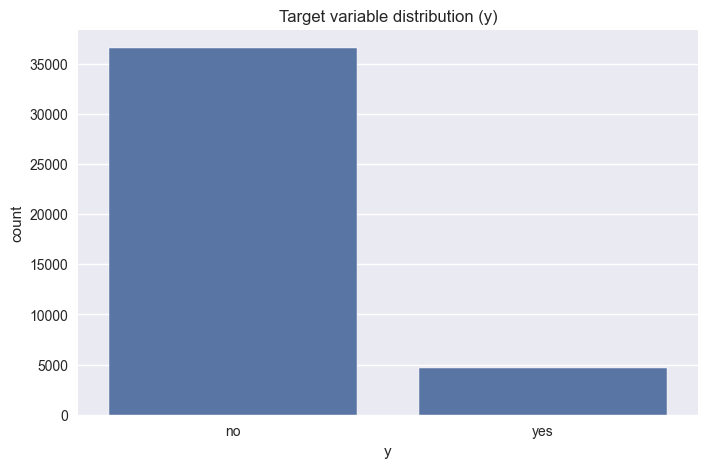

In [9]:
target_dist = df['y'].value_counts(normalize=True) * 100
print("Target variable distribution (%):")
print(target_dist)

sns.countplot(x='y', data=df)
plt.title("Target variable distribution (y)")
plt.show()


### 3.2 Variáveis Demográficas e Perfil do Cliente



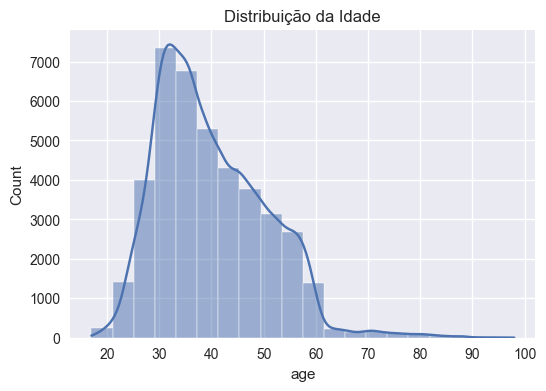

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Distribuição da Idade")
plt.show()

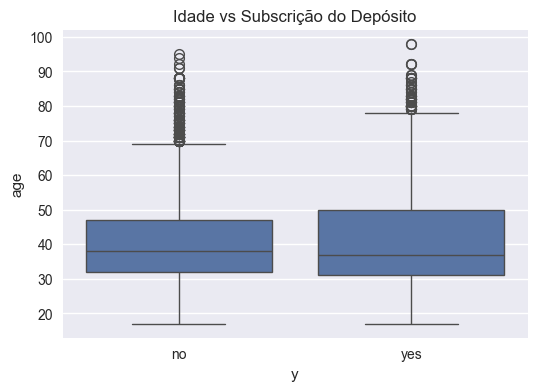

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['y'], y=df['age'])
plt.title("Idade vs Subscrição do Depósito")
plt.show()

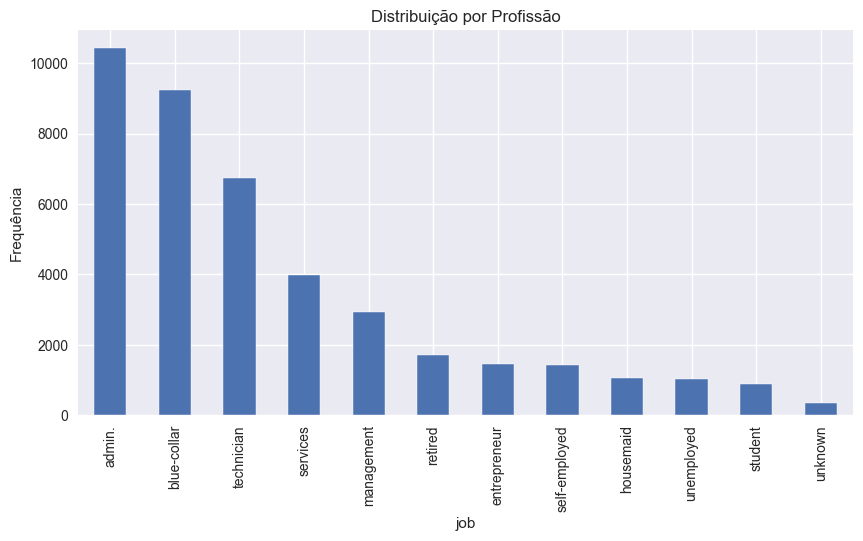

In [12]:
plt.figure(figsize=(10,5))
df['job'].value_counts().plot(kind='bar')
plt.title("Distribuição por Profissão")
plt.ylabel("Frequência")
plt.show()

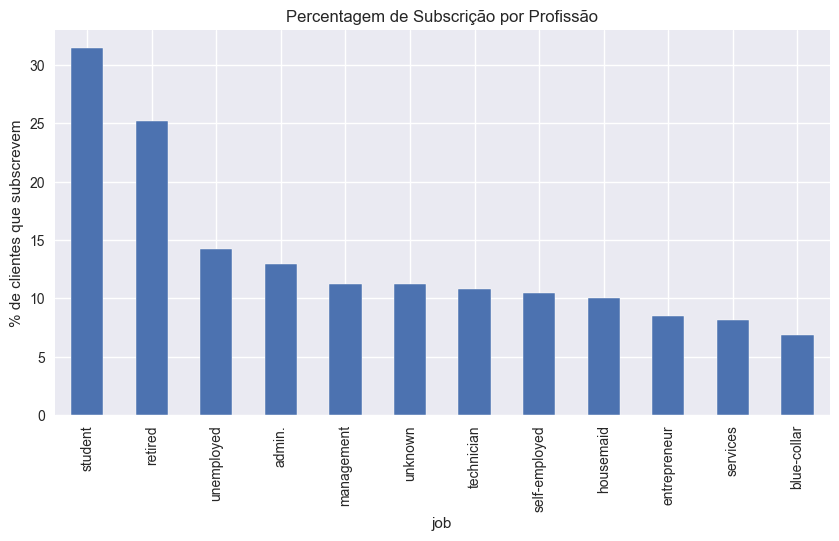

In [13]:
plt.figure(figsize=(10,5))
(df.groupby('job')['y'].value_counts(normalize=True)
 .rename("percent")
 .mul(100)
 .reset_index()
 .pivot(index='job', columns='y', values='percent')
)['yes'].sort_values(ascending=False).plot(kind='bar')
plt.title("Percentagem de Subscrição por Profissão")
plt.ylabel("% de clientes que subscrevem")
plt.show()

No que diz respeito à variável `age`, observa-se uma distribuição heterogénea, com maior concentração entre os 30 e 60 anos. O boxplot revela que, embora ambas as classes estejam distribuídas de forma semelhante, existe uma ligeira tendência de maior adesão entre clientes com idade superior a 40 anos.

Quanto à variável **profissão (`job`)**, verifica-se que categorias como *student*, *retired* e *unemployed* apresentam uma **percentagem mais elevada de subscrição** em comparação com trabalhadores do setor privado ou administrativo. Este padrão sugere que fatores económicos e disponibilidade financeira influenciam a probabilidade de adesão ao depósito a prazo.

### 3.3 Variáveis Relacionadas com a Campanha

### Número de Contactos na Campanha Atual (`campaign`)

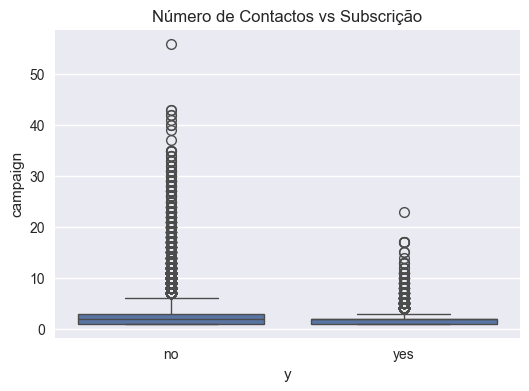

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['y'], y=df['campaign'])
plt.title("Número de Contactos vs Subscrição")
plt.show()


A variável `campaign` indica quantas vezes um cliente foi contactado durante a **campanha atual**. Verifica-se que clientes que foram contactados **muitas vezes** apresentam, em média, **menor probabilidade de subscrição**. Este comportamento é consistente com o fenómeno de **fadiga comercial**, no qual contactos sucessivos reduzem a predisposição do cliente para aceitar a oferta.

### 3.4 Variáveis Macroeconómicas

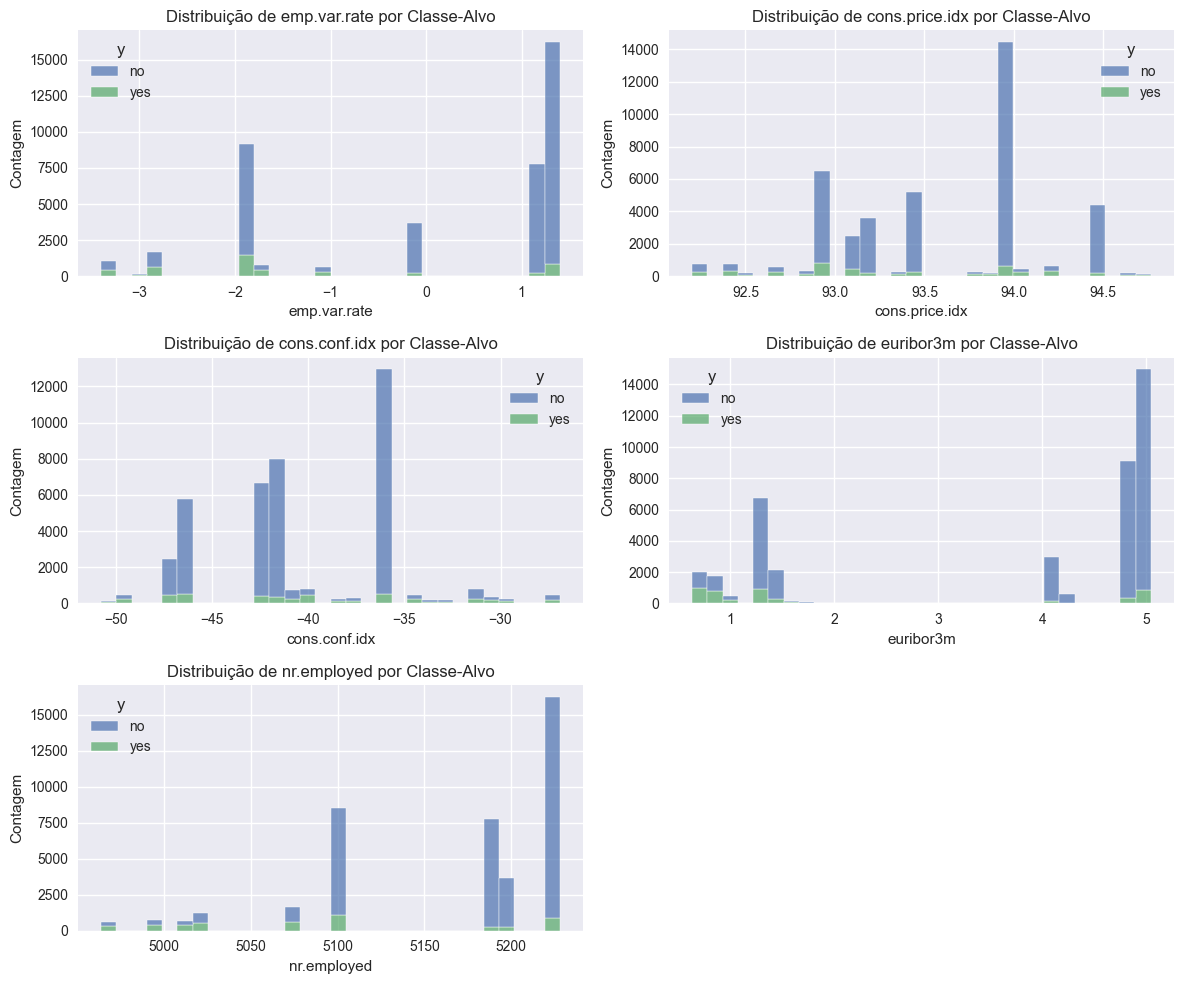

In [15]:
macro_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

plt.figure(figsize=(12,10))

for i, col in enumerate(macro_vars, 1):
    plt.subplot(3,2,i)
    sns.histplot(data=df, x=col, hue='y', multiple='stack', bins=30, alpha=0.7)
    plt.title(f"Distribuição de {col} por Classe-Alvo")
    plt.ylabel("Contagem")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


A análise dos histogramas por classe revela que o contexto económico influencia a probabilidade de subscrição:

- Para a variável **`euribor3m`**, observam-se maiores taxas de subscrição em períodos com **taxas de juro mais baixas**, o que torna os depósitos a prazo relativamente mais atrativos face a outros produtos financeiros.
- A variável **`cons.conf.idx`** (confiança do consumidor) apresenta uma distribuição ligeiramente deslocada para valores mais elevados na classe `yes`, sugerindo que clientes tendem a investir mais quando percecionam estabilidade económica.
- No caso de **`emp.var.rate`** e **`nr.employed`**, nota-se que fases económicas com menor dinamismo do mercado de trabalho correspondem a uma maior procura por produtos de poupança conservadora.
- A variável **`cons.price.idx`** apresenta diferenças menos expressivas entre classes, podendo ter papel menos determinante na decisão de subscrição.

No seu conjunto, estas observações indicam que **fatores macroeconómicos influenciam o comportamento financeiro dos clientes**, justificando a inclusão destas variáveis na fase de modelação.


### 3.5 Matriz de Correlação

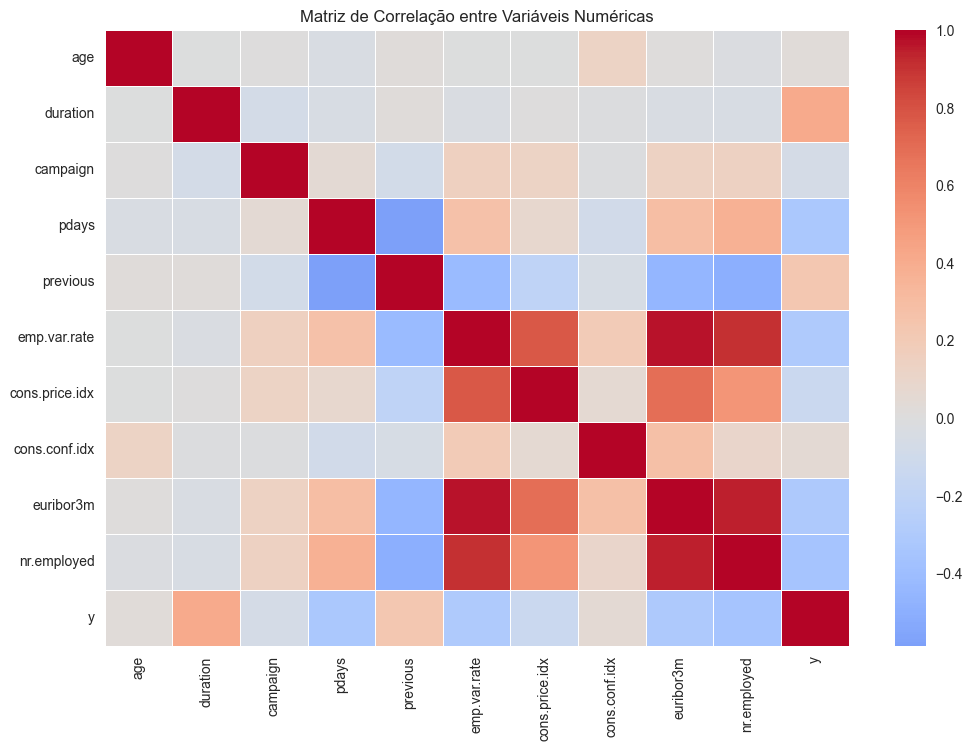

,Correlação com y
duration,0.405
previous,0.230
cons.conf.idx,0.055
age,0.030
campaign,-0.066
cons.price.idx,-0.136
emp.var.rate,-0.298
euribor3m,-0.308
pdays,-0.325
nr.employed,-0.355


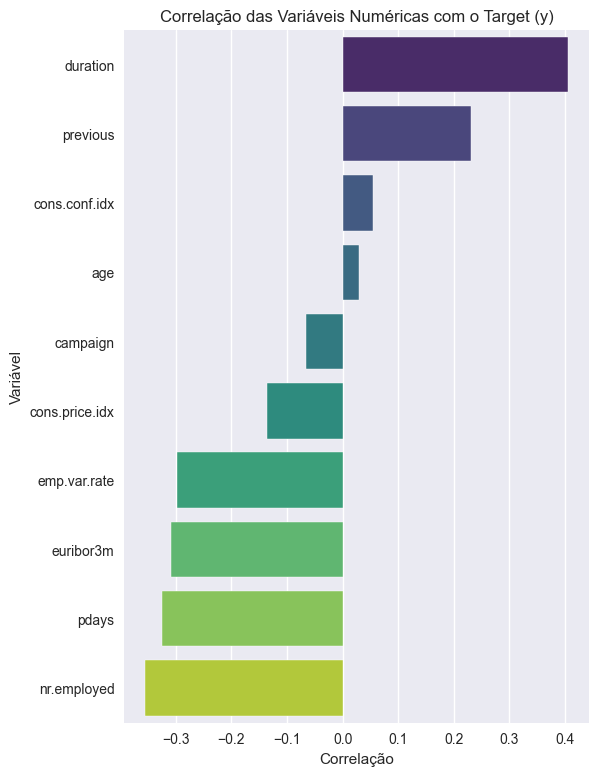

In [16]:
# Copiar dataset e converter a variável alvo para numérica
df_corr = df.copy()
df_corr['y'] = df_corr['y'].map({'no': 0, 'yes': 1})

# Calcular matriz de correlação numérica
corr_matrix = df_corr.select_dtypes(include='number').corr()

# Mostrar a matriz de correlação completa
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

# Mostrar correlação com o target em tabela
corr_target = corr_matrix['y'].drop('y').sort_values(ascending=False)
display(corr_target.to_frame("Correlação com y").style.format({"Correlação com y": "{:.3f}"}))

# Gráfico da correlação com o target (barplot vertical)
plt.figure(figsize=(6,9))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")
plt.title("Correlação das Variáveis Numéricas com o Target (y)")
plt.xlabel("Correlação")
plt.ylabel("Variável")
plt.show()



Após converter a variável alvo `y` para formato numérico (`no = 0`, `yes = 1`), torna-se possível analisar quantitativamente a relação entre cada variável numérica e a probabilidade de subscrição.

A variável `duration` apresenta a correlação positiva mais elevada com `y`, indicando que chamadas mais longas estão fortemente associadas à adesão ao depósito. No entanto, conforme descrito na documentação do dataset, a variável `duration` **não está disponível antes da chamada ser realizada**, sendo portanto utilizada apenas em modelos de *benchmark* e excluída do modelo operacional final.

Variáveis como `campaign` e `previous` apresentam correlação negativa com `y`, sugerindo que contactos repetidos com o mesmo cliente tendem a reduzir a probabilidade de conversão, refletindo um fenómeno de **fadiga comercial**.

As variáveis macroeconómicas (`euribor3m`, `emp.var.rate`, `cons.conf.idx`) exibem correlações de magnitude moderada, indicando que o contexto económico influencia a decisão de investimento do cliente.

Esta análise orienta a fase de modelação, permitindo selecionar e ajustar variáveis com impacto significativo na previsão do resultado.


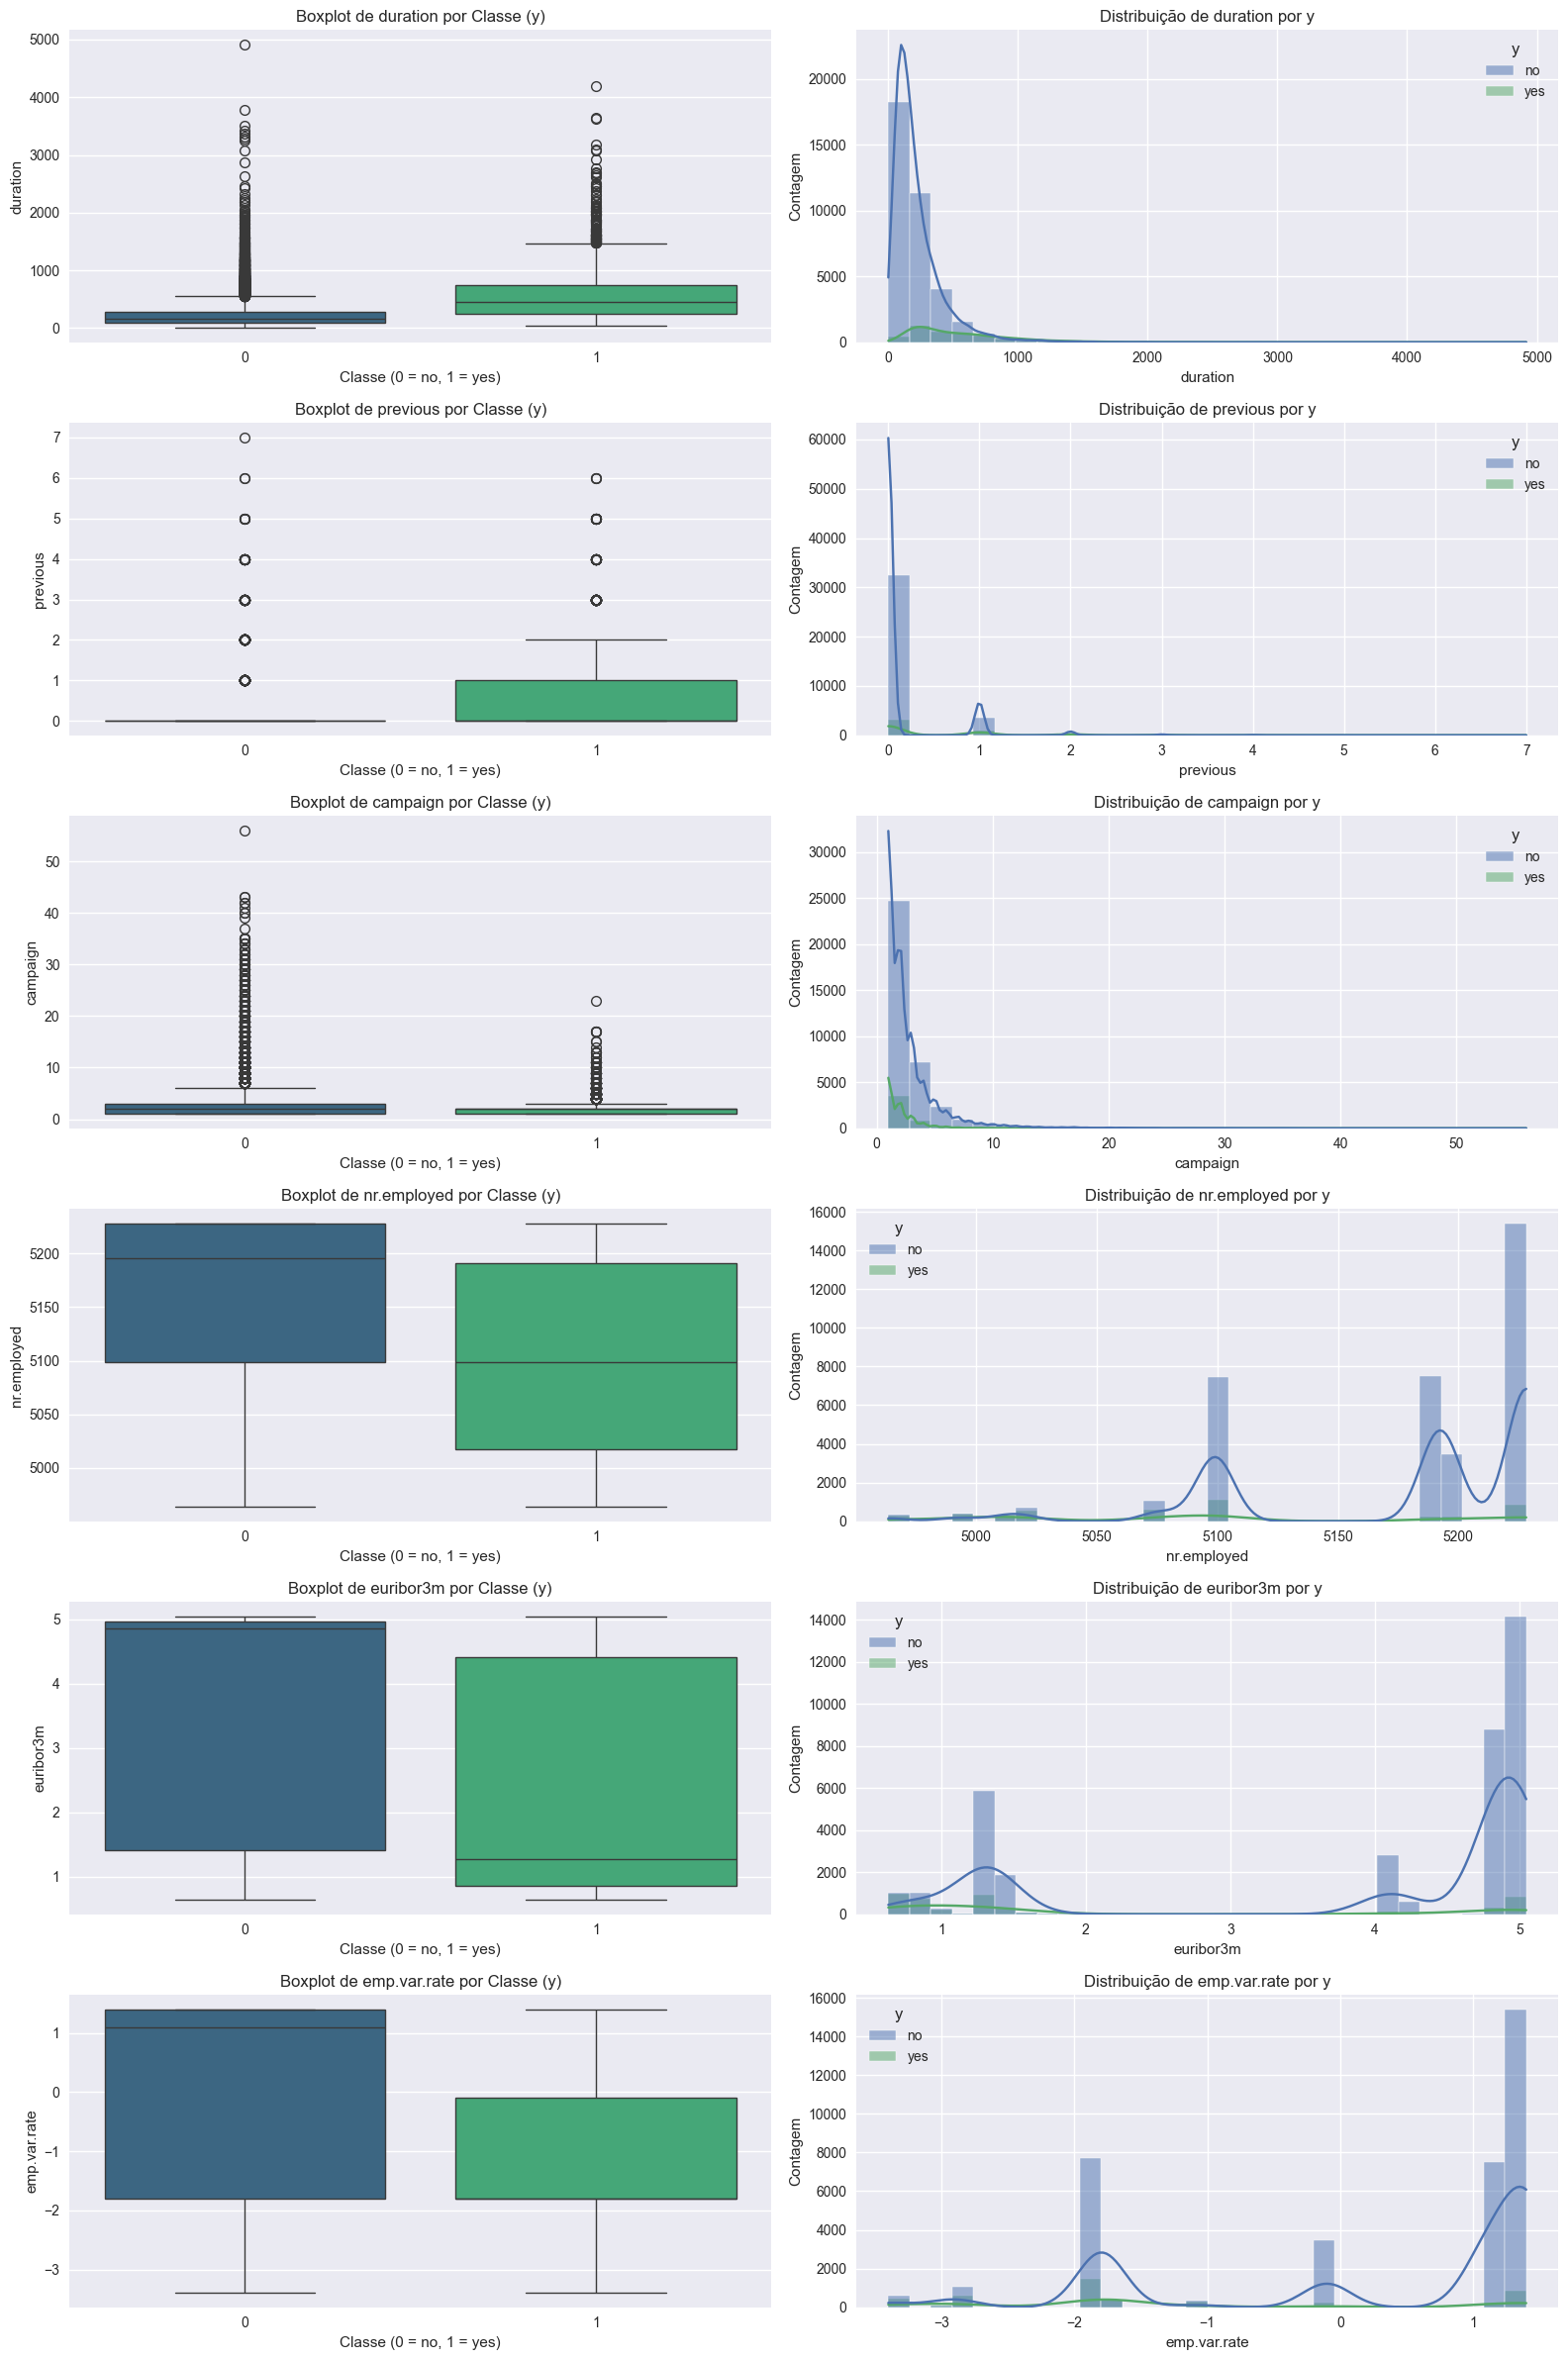

In [17]:
num_vars_to_plot = [
    'duration', 
    'previous', 
    'campaign',  
    'nr.employed', 
    'euribor3m', 
    'emp.var.rate'
]

# Garantir que apenas variáveis que existem são usadas
num_vars_to_plot = [v for v in num_vars_to_plot if v in df.columns]

# Converter y para binário apenas para visualização
y_bin = df['y'].map({'no':0,'yes':1})

fig, axes = plt.subplots(nrows=len(num_vars_to_plot), ncols=2, figsize=(16, 4*len(num_vars_to_plot)))

for i, var in enumerate(num_vars_to_plot):
    
    # Boxplot (y binário vs variável numérica)
    sns.boxplot(x=y_bin, y=df[var], ax=axes[i,0], palette='viridis')
    axes[i,0].set_title(f"Boxplot de {var} por Classe (y)")
    axes[i,0].set_xlabel("Classe (0 = no, 1 = yes)")
    axes[i,0].set_ylabel(var)
    
    # Histograma (distribuição por classe)
    sns.histplot(data=df, x=var, hue='y', bins=30, kde=True, ax=axes[i,1])
    axes[i,1].set_title(f"Distribuição de {var} por y")
    axes[i,1].set_xlabel(var)
    axes[i,1].set_ylabel("Contagem")

plt.tight_layout()
plt.show()


### Interpretação das Variáveis Numéricas

A variável **`duration`** é a que apresenta a correlação mais elevada com a subscrição do depósito (≈ 0.40). Nos boxplots verifica-se que as chamadas associadas a subscrição (`y = yes`) tendem a ter duração significativamente superior. Este comportamento sugere que a duração da chamada reflete o nível de envolvimento do cliente no momento do contacto. No entanto, dado que esta variável apenas é conhecida após a chamada, será incluída apenas no modelo de benchmark e excluída do modelo preditivo final.

A variável **`previous`** apresenta correlação moderada e o seu boxplot mostra que clientes com um histórico de contactos anteriores tendem a ter maior probabilidade de adesão. Este resultado reforça a importância da continuidade relacional: clientes já expostos ao produto têm maior propensão para o considerar numa nova campanha.

Observa-se ainda que valores elevados da variável **`campaign`** estão associados a menor probabilidade de subscrição. Este padrão evidencia o efeito de **fadiga comercial**: contactos repetidos podem reduzir o interesse do cliente ou transmitir insatisfação face à abordagem comercial. Assim, campanhas mais eficientes tendem a ocorrer nos primeiros contactos.

No que diz respeito às variáveis macroeconómicas, verifica-se que condições económicas desfavoráveis parecem associar-se a maior probabilidade de subscrição. Em particular:
- **`euribor3m`** apresenta correlação negativa, indicando que taxas de juro mais baixas favorecem a subscrição, uma vez que os depósitos se tornam relativamente mais atrativos face a produtos alternativos.
- **`nr.employed`** mostra também correlação negativa, sugerindo que períodos com menor dinamismo no mercado de trabalho incentivam a procura por soluções financeiras mais conservadoras.
- **`emp.var.rate`** reforça este efeito, sugerindo que campanhas realizadas em períodos de variação económica desfavorável apresentam maior taxa de adesão.

De forma global, estas análises revelam que a probabilidade de adesão ao depósito resulta da combinação entre:
- **Envolvimento e timing do contacto** (`duration`, `previous`, `campaign`);
- **Condições económicas externas** (`euribor3m`, `nr.employed`, `emp.var.rate`).

Este conjunto de evidências fundamenta as escolhas que serão implementadas na fase de modelação, nomeadamente a criação de um modelo com `duration` (benchmark) e outro sem `duration` (modelo realista aplicável antes da chamada).


### 3.5 Distribuição da Taxa de Subscrição por Categoria

In [18]:
for predictor in categorical_features:
    print(f"\nVariable: {predictor} (Percent %)")
    
    ct = pd.crosstab(df[predictor], df['y'], normalize='index') * 100
    ct = ct.rename(columns={0: 'no', 1: 'yes'}) if 1 in ct.columns else ct  
    ct = ct.sort_values(by='yes', ascending=False) if 'yes' in ct.columns else ct
    
    display(ct.style.format('{:.1f}%'))



Variable: education (Percent %)


y,no,yes
education,,
illiterate,77.8%,22.2%
unknown,85.5%,14.5%
university.degree,86.3%,13.7%
professional.course,88.7%,11.3%
high.school,89.2%,10.8%
basic.4y,89.8%,10.2%
basic.6y,91.8%,8.2%
basic.9y,92.2%,7.8%



Variable: job (Percent %)


y,no,yes
job,,
student,68.6%,31.4%
retired,74.8%,25.2%
unemployed,85.8%,14.2%
admin.,87.0%,13.0%
management,88.8%,11.2%
unknown,88.8%,11.2%
technician,89.2%,10.8%
self-employed,89.5%,10.5%
housemaid,90.0%,10.0%



Variable: day_of_week (Percent %)


y,no,yes
day_of_week,,
thu,87.9%,12.1%
tue,88.2%,11.8%
wed,88.3%,11.7%
fri,89.2%,10.8%
mon,90.1%,9.9%



Variable: poutcome (Percent %)


y,no,yes
poutcome,,
success,34.9%,65.1%
failure,85.8%,14.2%
nonexistent,91.2%,8.8%



Variable: default (Percent %)


y,no,yes
default,,
no,87.1%,12.9%
unknown,94.8%,5.2%
yes,100.0%,0.0%



Variable: month (Percent %)


y,no,yes
month,,
mar,49.5%,50.5%
dec,51.1%,48.9%
sep,55.1%,44.9%
oct,56.1%,43.9%
apr,79.5%,20.5%
aug,89.4%,10.6%
jun,89.5%,10.5%
nov,89.9%,10.1%
jul,91.0%,9.0%



Variable: contact (Percent %)


y,no,yes
contact,,
cellular,85.3%,14.7%
telephone,94.8%,5.2%



Variable: marital (Percent %)


y,no,yes
marital,,
unknown,85.0%,15.0%
single,86.0%,14.0%
divorced,89.7%,10.3%
married,89.8%,10.2%



Variable: housing (Percent %)


y,no,yes
housing,,
yes,88.4%,11.6%
no,89.1%,10.9%
unknown,89.2%,10.8%



Variable: loan (Percent %)


y,no,yes
loan,,
no,88.7%,11.3%
yes,89.1%,10.9%
unknown,89.2%,10.8%


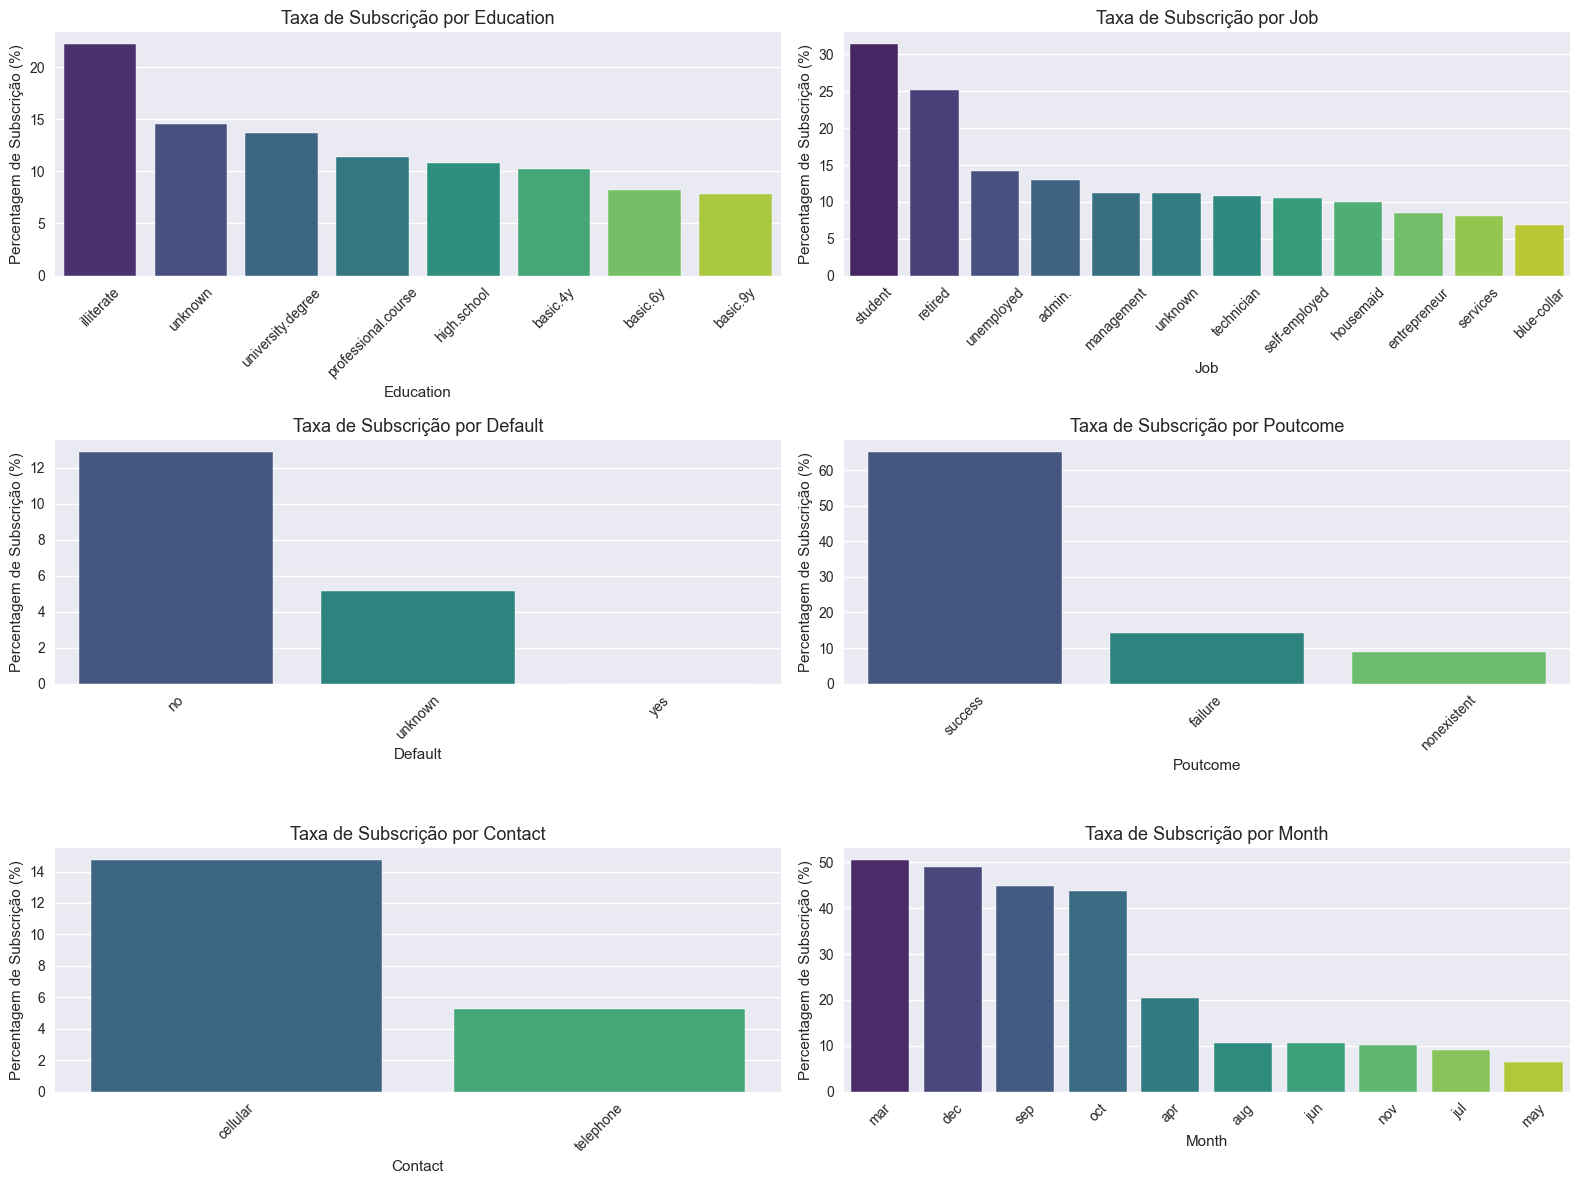

In [19]:
categorical_plot_vars = ['education', 'job', 'default', 'poutcome', 'contact', 'month']

rows = int(len(categorical_plot_vars) / 2) + len(categorical_plot_vars) % 2
fig, PlotCanvas = plt.subplots(nrows=rows, ncols=2, figsize=(16, 4*rows))

row = 0
col = 0

for var in categorical_plot_vars:
    
    # Percentagem de subscrição (yes) por categoria
    percent_yes = (
        df.groupby(var)['y']
        .apply(lambda x: (x == 'yes').mean() * 100)
        .sort_values(ascending=False)
    )

    # Selecionar eixo correto no grid
    ax = PlotCanvas[row, col]

    # Plot
    sns.barplot(
        x=percent_yes.index, 
        y=percent_yes.values, 
        palette="viridis",
        ax=ax
    )

    ax.set_title(f"Taxa de Subscrição por {var.capitalize()}", fontsize=13)
    ax.set_ylabel("Percentagem de Subscrição (%)")
    ax.set_xlabel(var.capitalize())
    ax.tick_params(axis='x', rotation=45)

    # avançar no grid
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.tight_layout()
plt.show()


In [20]:
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

### Interpretação dos Resultados das Variáveis Categóricas

A análise das taxas de subscrição por categoria permite identificar padrões claros de comportamento, relevantes para a definição de perfis-alvo da campanha.

No caso da variável **`education`**, embora a categoria `illiterate` apresente a maior taxa de subscrição (~22%), este resultado deve ser interpretado com cautela. A dimensão deste grupo no dataset é bastante reduzida, o que faz com que pequenas variações no número de subscrições tenham impacto significativo na percentagem final. Assim, este valor reflete mais um **efeito da reduzida representatividade amostral** do que um padrão comportamental generalizável.

As tendências mais robustas observam-se nas categorias com maior número de registos. Entre estas, destaca-se que níveis de escolaridade mais elevados, como `university.degree` (≈13–14%) e `professional.course` (≈11%), apresentam taxas de adesão superiores às de níveis básicos (ex.: `basic.9y`, `basic.6y` e `basic.4y`, com valores entre 7–10%). Este padrão sugere que a literacia financeira e o nível de formação estão positivamente associados à probabilidade de subscrição de produtos de investimento.


Relativamente à variável **`job`**, destacam-se duas categorias com taxa de adesão significativamente superior: *student* e *retired*. Este resultado pode indicar que estudantes têm maior abertura para oportunidades financeiras de baixo risco, enquanto indivíduos reformados tendem a ter maior disponibilidade de capital e preferência por soluções de poupança estáveis. Por outro lado, categorias como *blue-collar* e *services* apresentam percentagens inferiores, o que poderá refletir menor capacidade de investimento ou menor predisposição para produtos financeiros.

A variável **`default`** apresenta um comportamento determinante: clientes em situação de incumprimento (`default = yes`) não subscrevem o depósito, indicando restrição financeira clara. Já o grupo `"unknown"` apresenta uma taxa de subscrição inferior à categoria `"no"`, sugerindo que ausência de informação pode refletir incerteza ou perfil financeiro menos estruturado.

No que se refere ao **resultado da campanha anterior (`poutcome`)**, verifica-se um forte efeito histórico: clientes cujo último contacto resultou em *success* apresentam uma probabilidade de adesão bastante superior (65.1%). Este padrão reforça a importância da continuidade no relacionamento comercial, demonstrando que campanhas anteriores bem-sucedidas aumentam substancialmente a eficácia de campanhas futuras.

Quanto à variável **`contact`**, campanhas realizadas via *cellular* mostram-se mais eficazes do que via *telephone*. Este efeito pode relacionar-se com maior acessibilidade, disponibilidade ou personalização da comunicação via telemóvel.

Por fim, a evolução da taxa de subscrição ao longo dos **meses (`month`)** evidencia efeitos sazonais. Meses como **março, dezembro e setembro** apresentam taxas de adesão mais elevadas, enquanto **maio e julho** apresentam valores mais baixos. Este resultado sugere que a eficácia da campanha pode ser influenciada por fatores temporais, como ciclos salariais, contexto económico e planeamento financeiro pessoal.

---

### Síntese

Os resultados indicam que a probabilidade de adesão ao depósito não é uniforme entre os clientes, sendo fortemente influenciada por fatores socioeconómicos, perfil financeiro, histórico de interação com a instituição e sazonalidade.


## 4. Preparação dos Dados (Data Preparation)

A preparação dos dados tem como objetivo assegurar que o conjunto de dados se encontra em condições adequadas para a modelação, preservando o significado original das variáveis e evitando a introdução de enviesamentos. Todas as transformações aplicadas nesta fase seguem a documentação oficial do dataset e os resultados da análise exploratória previamente realizada.

As principais decisões de preparação são as seguintes:
1. **Remoção de Duplicados** efetuou-se a remoção das linhas duplicadas, para que não exista uma distorção e um enviesamento dos resultados.
2. **Remoção da coluna `duration`** como referido a cima, a coluna `duration` tem um impacto direto no resultado da variável target, logo não deverá ser utilizada para treinar os modelos.
4. **Verificação de valores Numéricos Nulos**
5. **Manutenção da categoria `"unknown"`:** esta categoria corresponde à ausência de resposta e não a valores omissos, pelo que é mantida como categoria válida na codificação.
6. **Recodificação da variável `pdays`:** A variável `pdays` usa `999` para indicar que o cliente **nunca foi contactado** em campanhas anteriores. Seguiu-se a tua abordagem:

- Criação do indicador binário **`was_prev_contacted`** (=1 se houve contacto anterior; =0 caso contrário).
- Manteve-se a coluna **`pdays`** que preserva a informação temporal **apenas para quem foi contactado** (clientes sem contacto anterior ficam com `NaN` nesta coluna).  
  Esta separação evita misturar o valor sentinela com dias reais e **melhora a interpretabilidade**.
7. **Codificação das variáveis categóricas:** realizada através de *One-Hot Encoding*, assegurando que não se perde informação semântica.
5. **Normalização das variáveis macroeconómicas:** aplicada apenas a variáveis com escalas numéricas incompatíveis, de modo a evitar distorções durante a modelação.
6. **Divisão treino/teste:** 80% dos dados são utilizados para treino e 20% para teste, utilizando estratificação para preservar a proporção das classes.
7. **Balanceamento da classe alvo:** são aplicadas e comparadas três estratégias:
   - `class_weight='balanced'`
   - **SMOTE** (sobreamostragem da classe minoritária)
Esta abordagem permite avaliar o impacto de diferentes técnicas de balanceamento, possibilitando recomendar o modelo mais adequado consoante o objetivo da campanha (maximizar adesões ou reduzir contactos improdutivos).


### Remoção de Duplicados

In [21]:
# Remove duplicate lines, if they exist

shape_before = df.shape
print('Shape before deleting duplicate values:',shape_before)

df = df.drop_duplicates()

shape_after = df.shape
print('Shape after deleting duplicate values:',shape_after)

percent = round((1-shape_after[0]/shape_before[0])*100,3)
print(f"Percentage of duplicates rows droped: {percent}%")

Shape before deleting duplicate values: (41188, 21)
Shape after deleting duplicate values: (41176, 21)
Percentage of duplicates rows droped: 0.029%


### Remoção da coluna `duration`

In [22]:
# Remoção da coluna duration para maior realismo do modelo
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

### Verificação de valores Numéricos Nulos

In [23]:
# Verificar valores nulos
print(df.isna().sum().sort_values(ascending=False).head(10))

age               0
job               0
nr.employed       0
euribor3m         0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
poutcome          0
previous          0
pdays             0
dtype: int64


### Manutenção da categoria `"unknown"`

In [24]:
# 1. Definir o total de registos (Número de linhas)
total_registos = len(df)
# 2. Lista de atributos categóricos com valores "unknown"
colunas_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# 3. Calcular a percentagem para cada coluna
resumo_unknown = {}

for coluna in colunas_unknown:
    # 3.1 Contar a frequência absoluta do valor 'unknown'
    # Usamos .get('unknown', 0) para garantir que não há erro se a categoria não existir na coluna
    contagem_unknown = df[coluna].value_counts().get('unknown', 0)
    
    # 3.2 Calcular a percentagem (agora dividindo por um escalar)
    percentagem = (contagem_unknown / total_registos) * 100
    
    # Armazenar os resultados
    resumo_unknown[coluna] = {
        'Contagem Unknown': contagem_unknown,
        'Percentagem (%)': round(percentagem, 2) 
    }

# 4. Exibir o resultado num DataFrame Pandas
df_resumo = pd.DataFrame(resumo_unknown).T
display(df_resumo.style.format({'Contagem Unknown': '{:.0f}', 'Percentagem (%)': '{:.2f} %'}))


,Contagem Unknown,Percentagem (%)
job,330,0.80 %
marital,80,0.19 %
education,1730,4.20 %
default,8596,20.88 %
housing,990,2.40 %
loan,990,2.40 %


Optou-se por substituir os valores unknown pela moda nas colunas job, marital, education, housing e loan uma vez que a ocorrência do valor nulo não é muito significativa (apenas na coluna education é um pouco mais elevado, porém não é um preditor com elevada relevância para o modelo)

In [25]:
def imputar_com_moda(df, coluna):
    valor_frequente = df[df[coluna] != 'unknow'][coluna].mode()[0]
    contagemantes = (df[coluna] == 'unknown').sum()
    
    df[coluna] = df[coluna].replace('unknown', valor_frequente)
    
    print(f"✓ {coluna}: Imputados {contagemantes} valores com '{valor_frequente}'")
    return df

In [26]:
df = imputar_com_moda(df, 'job')
df = imputar_com_moda(df, 'marital')
df = imputar_com_moda(df, 'housing')
df = imputar_com_moda(df, 'loan')
df = imputar_com_moda(df, 'education')

✓ job: Imputados 330 valores com 'admin.'
✓ marital: Imputados 80 valores com 'married'
✓ housing: Imputados 990 valores com 'yes'
✓ loan: Imputados 990 valores com 'no'
✓ education: Imputados 1730 valores com 'university.degree'


Como a coluna 'default' possui um elevado número de ocorrências 'unknown' optou-se por dummy encoding permitindo ao modelo aprender como se comportar quando o incumprimento ao crédito é desconhecido.

In [27]:
default_dummies = pd.get_dummies(df['default'], prefix='default')
df = df.drop('default', axis=1)
df = pd.concat([df, default_dummies], axis=1)

Utilizou-se One-Hot Encoding através da função pd.get_dummies(), uma vez que a coluna `default` tinha uma elevada percentagem de valores `"unknown"`, evitando assim perda ou manipulação de informação.

### Recodificação da variável `pdays`

No dataset do Bank Marketing, existe uma coluna chamada pdays, que representa:
    “Número de dias que passaram desde o último contacto com o cliente numa campanha anterior.”

O valor da coluna pode ser:
* Um número positivo → indica quantos dias passaram desde o último contacto (ex.: 5, 200...).
* 999 → significa que o cliente nunca foi contactado antes.

Logo, o 999 não é um número real, mas sim um código categórico especial, por isso, não pode ser tratado diretamente como número porque confunde o modelo. 
Assim passa a exister a coluna `was_prev_contacted` que tem o valor 1 em caso positivo e 0 em caso negativo e a coluna `pdays` deixa de ter os valores 999 anómalos que são substituídos por NaN.

In [28]:
df["was_prev_contacted"] = (df["pdays"] != 999).astype(int)
df["pdays"] = df["pdays"].replace(999, np.nan)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,default_no,default_unknown,default_yes,was_prev_contacted
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,True,False,False,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,False,True,False,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,True,False,False,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,True,False,False,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,True,False,False,0


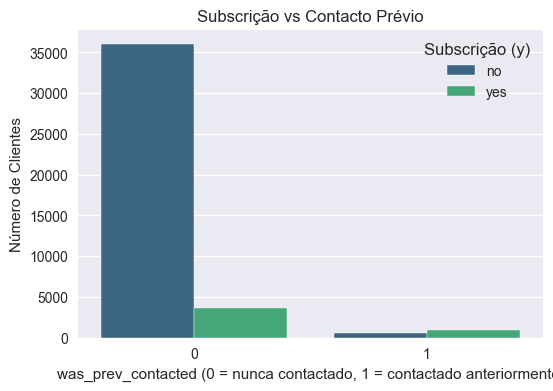

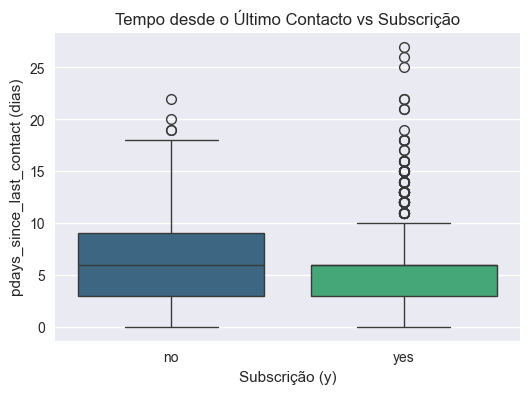

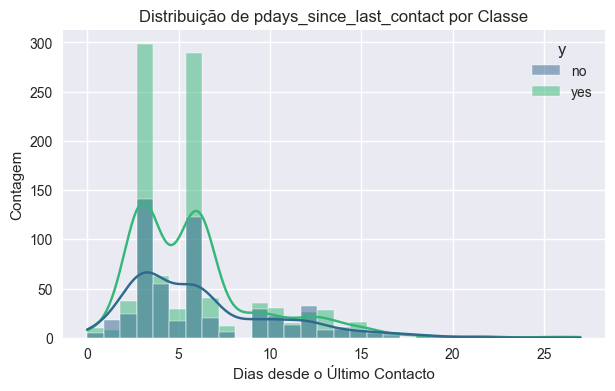

In [29]:
# 1) Histograma / Countplot para was_prev_contacted (variável binária)
plt.figure(figsize=(6,4))
sns.countplot(x='was_prev_contacted', hue='y', data=df, palette='viridis')
plt.title("Subscrição vs Contacto Prévio")
plt.xlabel("was_prev_contacted (0 = nunca contactado, 1 = contactado anteriormente)")
plt.ylabel("Número de Clientes")
plt.legend(title="Subscrição (y)")
plt.show()

# 2) Boxplot para pdays_since_last_contact
plt.figure(figsize=(6,4))
sns.boxplot(x='y', y='pdays', data=df, palette='viridis')
plt.title("Tempo desde o Último Contacto vs Subscrição")
plt.xlabel("Subscrição (y)")
plt.ylabel("pdays_since_last_contact (dias)")
plt.show()

# 3) Histograma para pdays_since_last_contact por classe
plt.figure(figsize=(7,4))
sns.histplot(data=df, x='pdays', hue='y', kde=True, bins=30, palette='viridis')
plt.title("Distribuição de pdays_since_last_contact por Classe")
plt.xlabel("Dias desde o Último Contacto")
plt.ylabel("Contagem")
plt.show()


### Interpretação das Variáveis Derivadas de `pdays`

A variável `was_prev_contacted` permite distinguir clientes que já tiveram contacto anterior da instituição daqueles que nunca foram abordados. O gráfico mostra que clientes que **nunca foram contactados** (`was_prev_contacted = 0`) constituem a maioria do dataset, e estes apresentam uma taxa de subscrição inferior à dos clientes já previamente contactados. Este padrão indica que a experiência prévia de interação reforça a predisposição para considerar o depósito.

A variável `pdays`, que representa o número de dias desde o último contacto (apenas para clientes previamente contactados), revela que **contactos mais recentes** estão associados a uma **probabilidade superior de adesão**. Nos boxplots observa-se que, para a classe `yes`, os valores de `pdays` tendem a ser mais baixos. Já valores elevados correspondem maioritariamente a `no`, sugerindo perda de interesse ao longo do tempo.

Em conjunto, estes resultados mostram que o **timing da campanha** desempenha um papel significativo na sua eficácia:  
- **contactos recentes fortalecem o envolvimento**, aumentando a probabilidade de conversão,  
- enquanto **intervalos longos enfraquecem o impacto da comunicação**.


### Outliers

In [30]:
outlier_cols = ['age', 'campaign', 'previous']

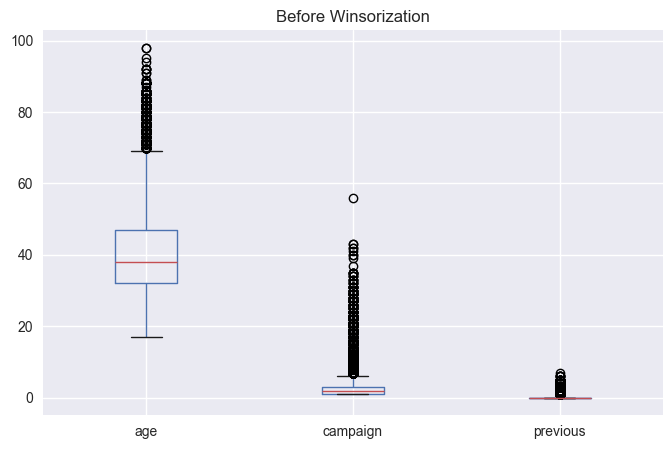

In [31]:
df[outlier_cols].boxplot(figsize=(8,5))
plt.title("Before Winsorization")
plt.show()


In [32]:
# --- Outlier treatment only for relevant numeric columns ---

for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)
    print(f"{col}: Winsorized to range [{lower:.2f}, {upper:.2f}]")


age: Winsorized to range [9.50, 69.50]
campaign: Winsorized to range [-2.00, 6.00]
previous: Winsorized to range [0.00, 0.00]


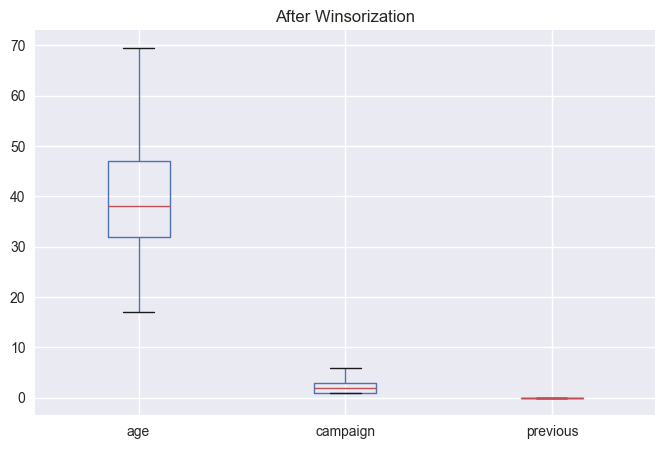

In [33]:
df[outlier_cols].boxplot(figsize=(8,5))
plt.title("After Winsorization")
plt.show()


In [34]:
df_norm = df.copy()

# Normalize text (remove spaces and make lowercase)
for col in df_norm.select_dtypes(include='object').columns:
    df_norm[col] = df_norm[col].astype(str).str.strip().str.lower()

# Encode all yes/no columns automatically
binary_cols = ['loan', 'housing']
for col in binary_cols:
    df_norm[col] = (df_norm[col] == 'yes').astype(int)


In [35]:
multi_cat = ['marital', 'education', 'job', 'month', 'day_of_week', 'poutcome', 'contact']

df_norm = pd.get_dummies(df_norm, columns=multi_cat, prefix_sep='_', drop_first=True)

In [36]:
default_cols = ['default_no', 'default_yes', 'default_unknown']
df_norm[default_cols] = df_norm[default_cols].astype(int)


In [37]:
print("Final number of features:", df_norm.shape[1])
df_norm.info()


Final number of features: 50
<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   housing                        41176 non-null  int64  
 2   loan                           41176 non-null  int64  
 3   campaign                       41176 non-null  int64  
 4   pdays                          1515 non-null   float64
 5   previous                       41176 non-null  int64  
 6   emp.var.rate                   41176 non-null  float64
 7   cons.price.idx                 41176 non-null  float64
 8   cons.conf.idx                  41176 non-null  float64
 9   euribor3m                      41176 non-null  float64
 10  nr.employed                    41176 non-null  float64
 11  y                              41176 non-null  object 
 12  default_no            

### 4.1 Seleção de Variáveis (Feature Selection)

Antes de avançar para a modelação, é necessário identificar quais as variáveis que mais contribuem para a previsão da variável alvo `y`. Esta etapa é fundamental, pois permite:

- Reduzir o risco de *overfitting*, removendo atributos redundantes ou irrelevantes;
- Melhorar a interpretabilidade do modelo;
- Diminuir o custo computacional do treino;
- Evitar ruído que possa prejudicar o desempenho dos modelos.

De acordo com o documento *MINDD-03-DataPreparation* (slides 42–49), foram aplicados métodos de **seleção de variáveis** pertencentes a duas categorias complementares:

| Tipo de Método | Técnica Utilizada | Aplicação | Justificação |
|---|---|---|---|
| **Filter Methods** | **ANOVA** (numéricas) e **Chi-Square** (categóricas) | Avaliar separadamente a relevância estatística das variáveis face ao alvo `y` | São rápidos, independentes do modelo e permitem descartar variáveis pouco informativas. |
| **Filter Não-Linear** | **Mutual Information (MI)** | Variáveis numéricas | Capta relações não-lineares entre as variáveis e o alvo, complementando o ANOVA. |
| **Embedded Method** | **LASSO (Logistic Regression L1)** | Todas as variáveis | Realiza seleção automática ao forçar coeficientes irrelevantes a zero, reduzindo multicolinearidade. |

A abordagem adotada foi **híbrida**:

1. Foram identificadas variáveis relevantes utilizando testes estatísticos (Filter Methods);
2. Aplicou-se a técnica de **LASSO** para reforçar a eliminação de atributos redundantes;
3. A seleção final resultou da **interseção** entre os métodos, obtendo um conjunto final de variáveis mais estável, interpretável e adequado para os modelos de classificação.

Este procedimento garante que apenas as variáveis com maior relevância preditiva são utilizadas na modelação.


In [38]:
# Definir X e y após o encoding

df_norm["pdays"] = df_norm["pdays"].replace(np.nan, 0)
y = df_norm['y']
X = df_norm.drop('y', axis=1)


# Converter y para binário se ainda não estiver
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Separação das features numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# ANOVA
anova_scores, _ = f_classif(X[numeric_features], y)
anova_rank = pd.Series(anova_scores, index=numeric_features).rank(ascending=False)

# Mutual Information (não-linear)
mi_scores = mutual_info_classif(X[numeric_features], y, random_state=42)
mi_rank = pd.Series(mi_scores, index=numeric_features).rank(ascending=False)

# Combinação ponderada ANOVA + MI
numeric_combined = (anova_rank + mi_rank) / 2

# Selecionar TOP 12 variáveis numéricas
numeric_selected = numeric_combined.sort_values().head(12).index.tolist()

print("Variáveis numéricas selecionadas:")
numeric_selected


Variáveis numéricas selecionadas:


['euribor3m',
 'nr.employed',
 'cons.price.idx',
 'was_prev_contacted',
 'emp.var.rate',
 'pdays',
 'cons.conf.idx',
 'default_no',
 'default_unknown',
 'age',
 'campaign',
 'housing']

In [39]:
# Separação das dummies
categorical_features = X.select_dtypes(include=['uint8', 'bool']).columns

# Escalar antes do chi2 (requisito da estatística)
scaler = MinMaxScaler()
X_cat_scaled = scaler.fit_transform(X[categorical_features])

# Chi-Square
chi_scores, _ = chi2(X_cat_scaled, y)
chi_rank = pd.Series(chi_scores, index=categorical_features).rank(ascending=False)

# Selecionar TOP 12 variáveis categóricas
categorical_selected = chi_rank.sort_values().head(12).index.tolist()

print("Variáveis categóricas selecionadas:")
categorical_selected


Variáveis categóricas selecionadas:


['poutcome_success',
 'month_mar',
 'month_oct',
 'month_sep',
 'contact_telephone',
 'job_student',
 'job_retired',
 'month_may',
 'month_dec',
 'poutcome_nonexistent',
 'job_blue-collar',
 'education_university.degree']

In [40]:
# Standard scaling antes da Lasso
scaler_std = StandardScaler()
X_scaled = scaler_std.fit_transform(X)

lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.1,
    max_iter=2000,
    random_state=42
)
lasso.fit(X_scaled, y)

lasso_coef = pd.Series(lasso.coef_[0], index=X.columns)
lasso_selected = list(lasso_coef[lasso_coef != 0].index)

print("Variáveis selecionadas pelo LASSO:")
lasso_selected


Variáveis selecionadas pelo LASSO:


['housing',
 'loan',
 'campaign',
 'pdays',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'default_no',
 'default_yes',
 'was_prev_contacted',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone']

In [41]:
# Interseção de Filter + Embedded
final_features = list(set(numeric_selected + categorical_selected).intersection(lasso_selected))

print(f"Nº total de features selecionadas: {len(final_features)}\n")
print("Features finais selecionadas:\n")
for f in final_features:
    print(f"- {f}")



Nº total de features selecionadas: 21

Features finais selecionadas:

- cons.price.idx
- education_university.degree
- default_no
- pdays
- cons.conf.idx
- job_retired
- month_oct
- job_student
- housing
- month_may
- poutcome_nonexistent
- emp.var.rate
- poutcome_success
- campaign
- month_mar
- euribor3m
- was_prev_contacted
- contact_telephone
- job_blue-collar
- month_sep
- month_dec


### Resultados da Seleção de Variáveis

Os testes estatísticos realizados permitiram identificar os atributos com maior capacidade discriminativa na previsão da subscrição.  
Assim, o conjunto final de variáveis selecionadas combina:

- Variáveis categóricas significativamente associadas ao comportamento do cliente;
- Variáveis numéricas cuja distribuição difere entre subscritores e não-subscritores.

Estas variáveis serão agora utilizadas na construção dos modelos preditivos.


Dado que o objetivo do banco é identificar o maior número possível de potenciais subscritores (classe minoritária “yes”), a métrica prioritária escolhida é o Recall, de forma a minimizar falsos negativos. Telefonar a um cliente que não subscreve é menos crítico do que deixar de contactar alguém que poderia efetivamente aceitar.

In [42]:
# 1) Garantir que o target está binário
df_norm['y'] = df_norm['y'].map({'no': 0, 'yes': 1}).astype(int)

# 2) Filtrar apenas features que realmente existem no df_norm
final_features_aligned = [f for f in final_features if f in df_norm.columns]

print("Número de features selecionadas que existem no df_norm:", len(final_features_aligned))
print(final_features_aligned)

# 3) Criar o dataset final
dfML = df_norm[final_features_aligned + ['y']].copy()

dfML.head()


Número de features selecionadas que existem no df_norm: 21
['cons.price.idx', 'education_university.degree', 'default_no', 'pdays', 'cons.conf.idx', 'job_retired', 'month_oct', 'job_student', 'housing', 'month_may', 'poutcome_nonexistent', 'emp.var.rate', 'poutcome_success', 'campaign', 'month_mar', 'euribor3m', 'was_prev_contacted', 'contact_telephone', 'job_blue-collar', 'month_sep', 'month_dec']


,cons.price.idx,education_university.degree,default_no,pdays,cons.conf.idx,job_retired,month_oct,job_student,housing,month_may,poutcome_nonexistent,emp.var.rate,poutcome_success,campaign,month_mar,euribor3m,was_prev_contacted,contact_telephone,job_blue-collar,month_sep,month_dec,y
0,93.99,False,1,0.00,-36.40,False,False,False,0,True,True,1.10,False,1,False,4.86,0,True,False,False,False,0
1,93.99,False,0,0.00,-36.40,False,False,False,0,True,True,1.10,False,1,False,4.86,0,True,False,False,False,0
2,93.99,False,1,0.00,-36.40,False,False,False,1,True,True,1.10,False,1,False,4.86,0,True,False,False,False,0
3,93.99,False,1,0.00,-36.40,False,False,False,0,True,True,1.10,False,1,False,4.86,0,True,False,False,False,0
4,93.99,False,1,0.00,-36.40,False,False,False,0,True,True,1.10,False,1,False,4.86,0,True,False,False,False,0


In [43]:
X = dfML.drop("y", axis=1)
y = dfML["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Tamanho Treino:", X_train.shape)
print("Tamanho Teste:", X_test.shape)
print("\nDistribuição no treino:\n", y_train.value_counts(normalize=True))
print("\nDistribuição no teste:\n", y_test.value_counts(normalize=True))


Tamanho Treino: (32940, 21)
Tamanho Teste: (8236, 21)

Distribuição no treino:
 y
0   0.89
1   0.11
Name: proportion, dtype: float64

Distribuição no teste:
 y
0   0.89
1   0.11
Name: proportion, dtype: float64


In [44]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [45]:
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

## 4. Modelação (CRISP-DM)

Nesta fase, procedeu-se à construção e avaliação de modelos preditivos com o objetivo de estimar a probabilidade de subscrição (`y`).  
Foram considerados algoritmos de diferentes naturezas, permitindo comparar desempenho, complexidade e interpretabilidade:

- **Modelos Lineares:** Logistic Regression  
- **Modelos Baseados em Árvores:** Decision Tree, Random Forest, XGBoost  
- **Modelos Probabilísticos:** Naive Bayes  
- **Modelos Baseados em Distâncias:** K-Nearest Neighbors (KNN)  
- **Modelos de Aprendizagem Profunda:** Rede Neural Artificial (Multilayer Perceptron – MLP)

A inclusão da **Rede Neural** tem como objetivo avaliar um modelo capaz de capturar relações **não lineares complexas**, oferecendo potencialmente melhor desempenho, embora com menor interpretabilidade.

### Justificação da Diversidade de Modelos

| Tipo de Modelo | Vantagens | Limitações |
|---|---|---|
| Lineares | Alta interpretabilidade | Podem falhar em relações não lineares |
| Árvores | Captam relações complexas sem normalização | Podem sobreajustar |
| Distância | Simples e intuitivos | Sensíveis à escala dos dados |
| Probabilísticos | Rápidos | Assumem independência entre atributos |
| Redes Neuronais | Flexíveis e expressivas | Requerem normalização e maior poder computacional |

### Estratégia de Validação

Para garantir fiabilidade na avaliação, foi utilizado **Cross-Validation (k-fold)**, evitando dependência de uma única divisão de treino/teste.  
Além disso, o modelo final será selecionado considerando:

- **Recall da classe positiva** (clientes que subscrevem),
- **F1-Score** (equilíbrio entre precisão e recall),
- **AUC-ROC** (capacidade discriminativa global).

Esta abordagem assegura que o modelo escolhido é **não só preciso**, mas também **útil para apoiar a decisão estratégica nas campanhas de marketing**.


In [46]:
def avaliar(model, X_te, y_te):
    # Predição das classes
    preds = model.predict(X_te)
    
    # Predição das probabilidades (necessária para ROC)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_te)[:, 1]
    else:
        print("Modelo não tem predict_proba() — ROC não será exibida.")
        probs = None

    # ------------------------------
    # MATRIZ DE CONFUSÃO
    # ------------------------------
    cm = confusion_matrix(y_te, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    
    plt.figure(figsize=(5,4))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Matriz de Confusão")
    plt.show()

    # ------------------------------
    # MÉTRICAS PRINCIPAIS
    # ------------------------------
    print(f"Recall (classe 'yes' / 1): {recall_score(y_te, preds):.3f}\n")
    print("Relatório de Classificação:\n")
    print(classification_report(y_te, preds, target_names=['No', 'Yes']))

    # ------------------------------
    # CURVA ROC (se aplicável)
    # ------------------------------
    if probs is not None:
        fpr, tpr, thresholds = roc_curve(y_te, probs)
        auc = roc_auc_score(y_te, probs)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkblue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("Curva ROC")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

#### **4.1 Logistic Regression**

Logistic Regression


<Figure size 500x400 with 0 Axes>

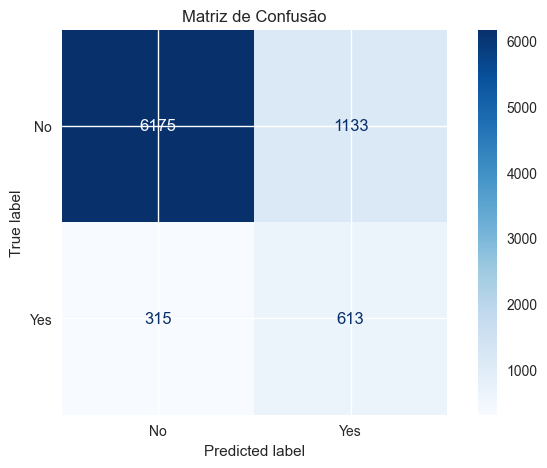

Recall (classe 'yes' / 1): 0.661

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.95      0.84      0.90      7308
         Yes       0.35      0.66      0.46       928

    accuracy                           0.82      8236
   macro avg       0.65      0.75      0.68      8236
weighted avg       0.88      0.82      0.85      8236



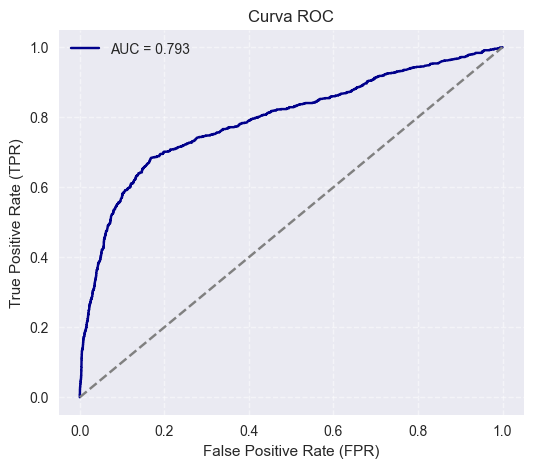

In [47]:
lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
lr.fit(X_train_bal_scaled, y_train_bal)

print("Logistic Regression")
avaliar(lr, X_test_scaled, y_test)


#### **4.2 Neural Network**

Neural Network


<Figure size 500x400 with 0 Axes>

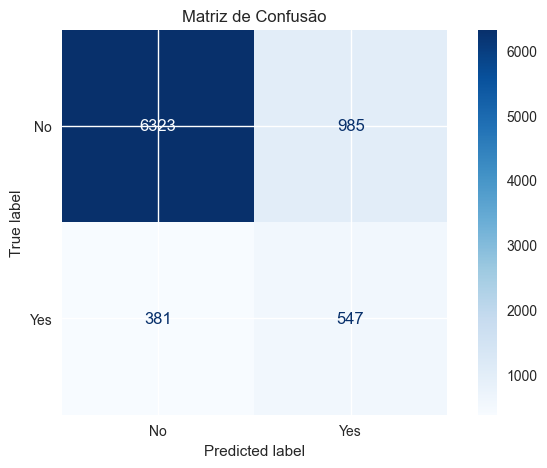

Recall (classe 'yes' / 1): 0.589

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.94      0.87      0.90      7308
         Yes       0.36      0.59      0.44       928

    accuracy                           0.83      8236
   macro avg       0.65      0.73      0.67      8236
weighted avg       0.88      0.83      0.85      8236



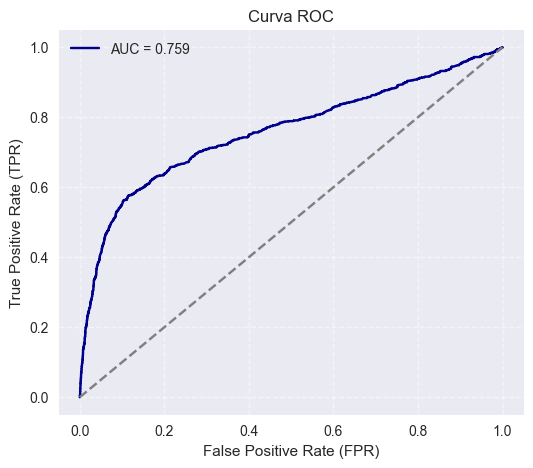

In [48]:
mlp = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', max_iter=400, random_state=42)
mlp.fit(X_train_bal_scaled, y_train_bal)

print("Neural Network")
avaliar(mlp, X_test_scaled, y_test)

#### **4.3 Random Forest**

Random Forest


<Figure size 500x400 with 0 Axes>

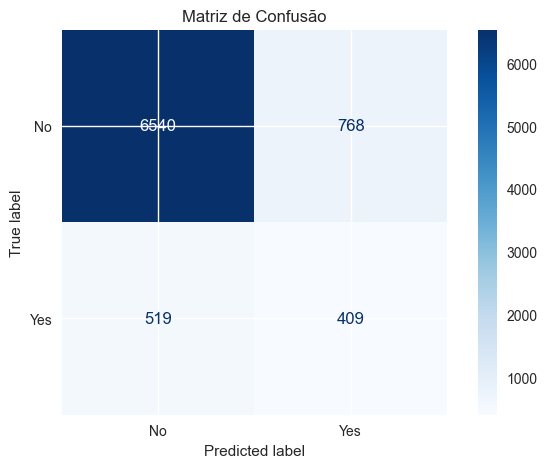

Recall (classe 'yes' / 1): 0.441

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.93      0.89      0.91      7308
         Yes       0.35      0.44      0.39       928

    accuracy                           0.84      8236
   macro avg       0.64      0.67      0.65      8236
weighted avg       0.86      0.84      0.85      8236



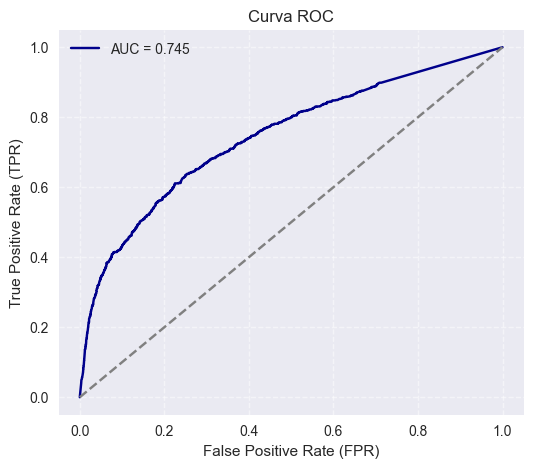

In [49]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf.fit(X_train_bal, y_train_bal)

print("Random Forest")
avaliar(rf, X_test, y_test)

#### **4.4 XGBoost**

XGBoost


<Figure size 500x400 with 0 Axes>

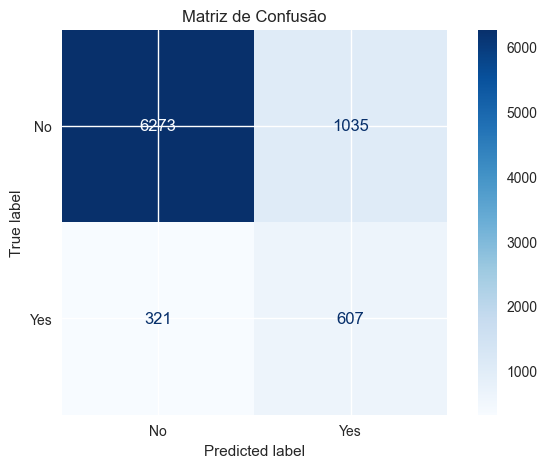

Recall (classe 'yes' / 1): 0.654

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.95      0.86      0.90      7308
         Yes       0.37      0.65      0.47       928

    accuracy                           0.84      8236
   macro avg       0.66      0.76      0.69      8236
weighted avg       0.89      0.84      0.85      8236



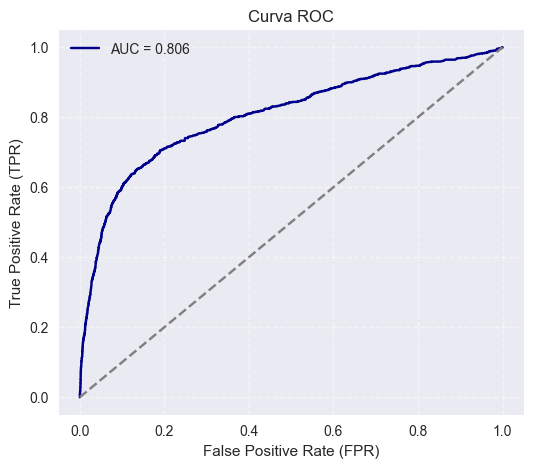

In [50]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=300
)

xgb.fit(X_train, y_train)
print("XGBoost")
avaliar(xgb, X_test, y_test)


#### **4.4 KNN**

KNN


<Figure size 500x400 with 0 Axes>

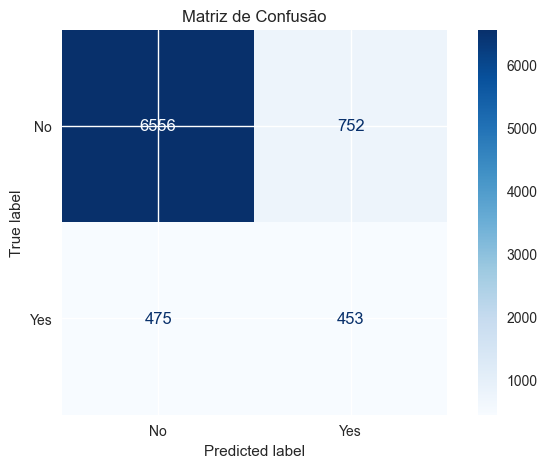

Recall (classe 'yes' / 1): 0.488

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.93      0.90      0.91      7308
         Yes       0.38      0.49      0.42       928

    accuracy                           0.85      8236
   macro avg       0.65      0.69      0.67      8236
weighted avg       0.87      0.85      0.86      8236



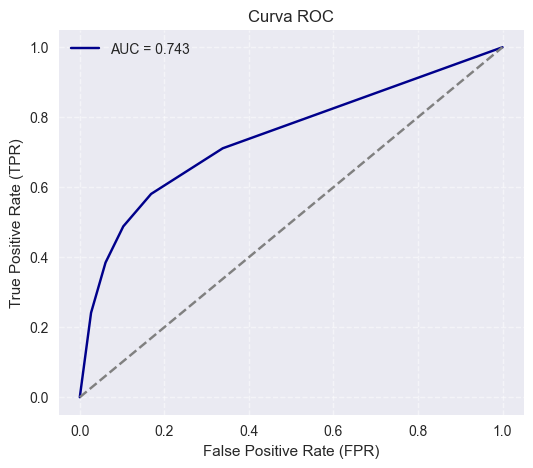

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_bal_scaled, y_train_bal)

print("KNN")
avaliar(knn, X_test_scaled, y_test)


#### **4.5 Naive Bayes**

Naive Bayes


<Figure size 500x400 with 0 Axes>

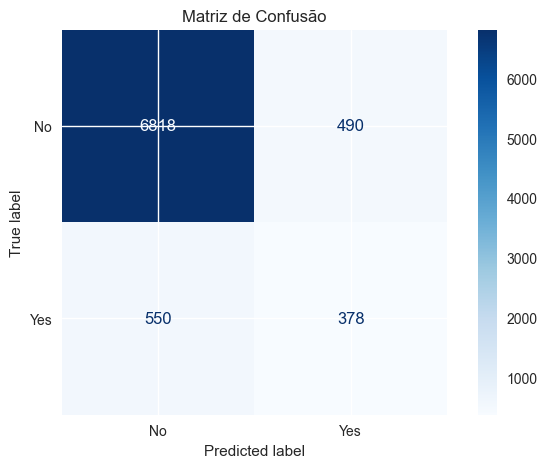

Recall (classe 'yes' / 1): 0.407

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.93      0.93      0.93      7308
         Yes       0.44      0.41      0.42       928

    accuracy                           0.87      8236
   macro avg       0.68      0.67      0.68      8236
weighted avg       0.87      0.87      0.87      8236



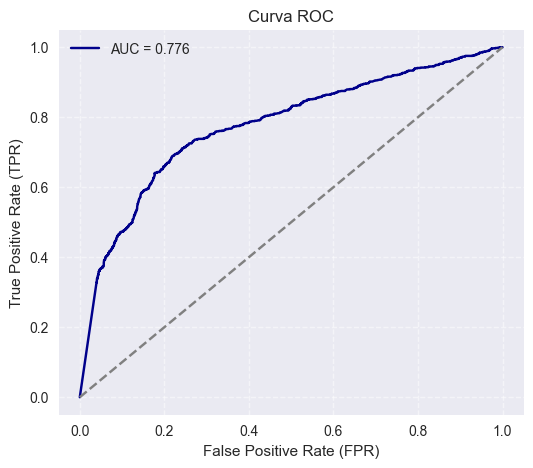

In [52]:
nb = GaussianNB()
nb.fit(X_train_bal_scaled, y_train_bal)

print("Naive Bayes")
avaliar(nb, X_test_scaled, y_test)


#### **4.6 DecisionTree**

Decision Tree


<Figure size 500x400 with 0 Axes>

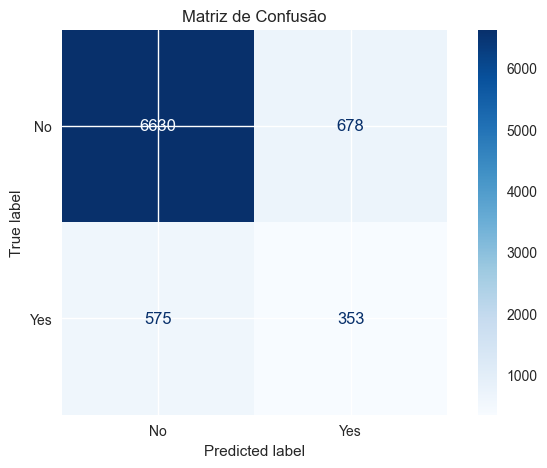

Recall (classe 'yes' / 1): 0.380

Relatório de Classificação:

              precision    recall  f1-score   support

          No       0.92      0.91      0.91      7308
         Yes       0.34      0.38      0.36       928

    accuracy                           0.85      8236
   macro avg       0.63      0.64      0.64      8236
weighted avg       0.86      0.85      0.85      8236



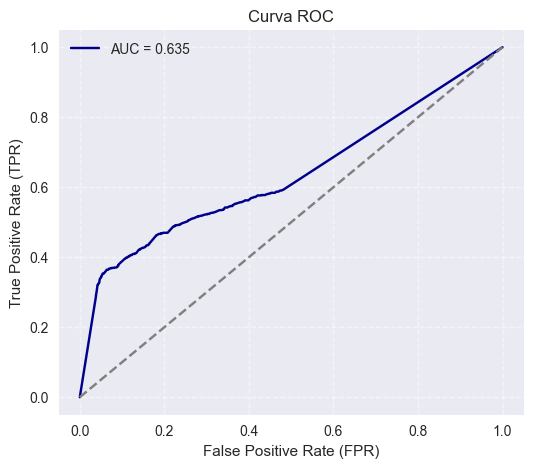

In [53]:
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

dt.fit(X_train_bal, y_train_bal)

print("Decision Tree")
avaliar(dt, X_test, y_test)


## 5. Evaluation — Explicação

Após o treino e avaliação dos diferentes modelos de classificação, foram analisadas as principais métricas de desempenho: **Accuracy**, **Precision**, **Recall**, **F1-score** e **AUC**. A tabela anterior resume os resultados obtidos.

Cada métrica representa um aspeto distinto do desempenho do modelo:

- **Accuracy**: percentagem global de classificações corretas. No entanto, num problema **desbalanceado** (muito mais “no” do que “yes”), a Accuracy pode ser **enganadora**, pois um modelo pode acertar muitas vezes o “no” e, ainda assim, falhar demasiados “yes”.

- **Precision**: entre os clientes previstos como *“yes”*, quantos realmente subscreveram. Uma precision baixa significa que o modelo faz chamadas “desnecessárias” — mas no contexto deste problema, esse custo é baixo.

- **Recall (classe “yes”)**: entre todos os clientes que **de facto** subscreveriam (classe positiva real), quantos o modelo conseguiu identificar.  
  **Esta é a métrica mais importante neste contexto**, porque o objetivo da campanha bancária é **não perder oportunidades** — ou seja:
  
  > É preferível telefonar a alguém que vai dizer “não” do que **não telefonar a alguém que teria dito “sim”**.

- **F1-score**: equilíbrio entre Precision e Recall — útil quando quer-se um compromisso entre errar pouco nos positivos e negativos.

- **AUC**: capacidade do modelo distinguir corretamente “yes” de “no” ao longo de vários limiares de decisão.
 


In [54]:

# Previsões para modelos com scaling
y_pred_lr = lr.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)
y_pred_nb = nb.predict(X_test_scaled)
y_pred_mlp = mlp.predict(X_test_scaled)

# Previsões para modelos sem scaling
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Probabilidades (necessárias para AUC)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]
y_prob_nb = nb.predict_proba(X_test_scaled)[:,1]
y_prob_mlp = mlp.predict_proba(X_test_scaled)[:,1]

y_prob_dt = dt.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

# Tabela de resultados
results = [
    ["Logistic Regression", accuracy_score(y_test, y_pred_lr), precision_score(y_test, y_pred_lr),
     recall_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lr), roc_auc_score(y_test, y_prob_lr)],

    ["Decision Tree", accuracy_score(y_test, y_pred_dt), precision_score(y_test, y_pred_dt),
     recall_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt), roc_auc_score(y_test, y_prob_dt)],

    ["Random Forest", accuracy_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf),
     recall_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)],

    ["KNN", accuracy_score(y_test, y_pred_knn), precision_score(y_test, y_pred_knn),
     recall_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn), roc_auc_score(y_test, y_prob_knn)],

    ["Naive Bayes", accuracy_score(y_test, y_pred_nb), precision_score(y_test, y_pred_nb),
     recall_score(y_test, y_pred_nb), f1_score(y_test, y_pred_nb), roc_auc_score(y_test, y_prob_nb)],

    ["MLP Neural Network", accuracy_score(y_test, y_pred_mlp), precision_score(y_test, y_pred_mlp),
     recall_score(y_test, y_pred_mlp), f1_score(y_test, y_pred_mlp), roc_auc_score(y_test, y_prob_mlp)],

    ["XGBoost", accuracy_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_xgb),
     recall_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb)],
]

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]).round(3)
df_results = df_results.sort_values(by="Recall", ascending=False)  # Ordenar por recall

display(df_results)


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.82,0.35,0.66,0.46,0.79
6,XGBoost,0.83,0.37,0.65,0.47,0.81
5,MLP Neural Network,0.83,0.36,0.59,0.45,0.76
3,KNN,0.85,0.38,0.49,0.42,0.74
2,Random Forest,0.84,0.35,0.44,0.39,0.74
4,Naive Bayes,0.87,0.43,0.41,0.42,0.78
1,Decision Tree,0.85,0.34,0.38,0.36,0.64


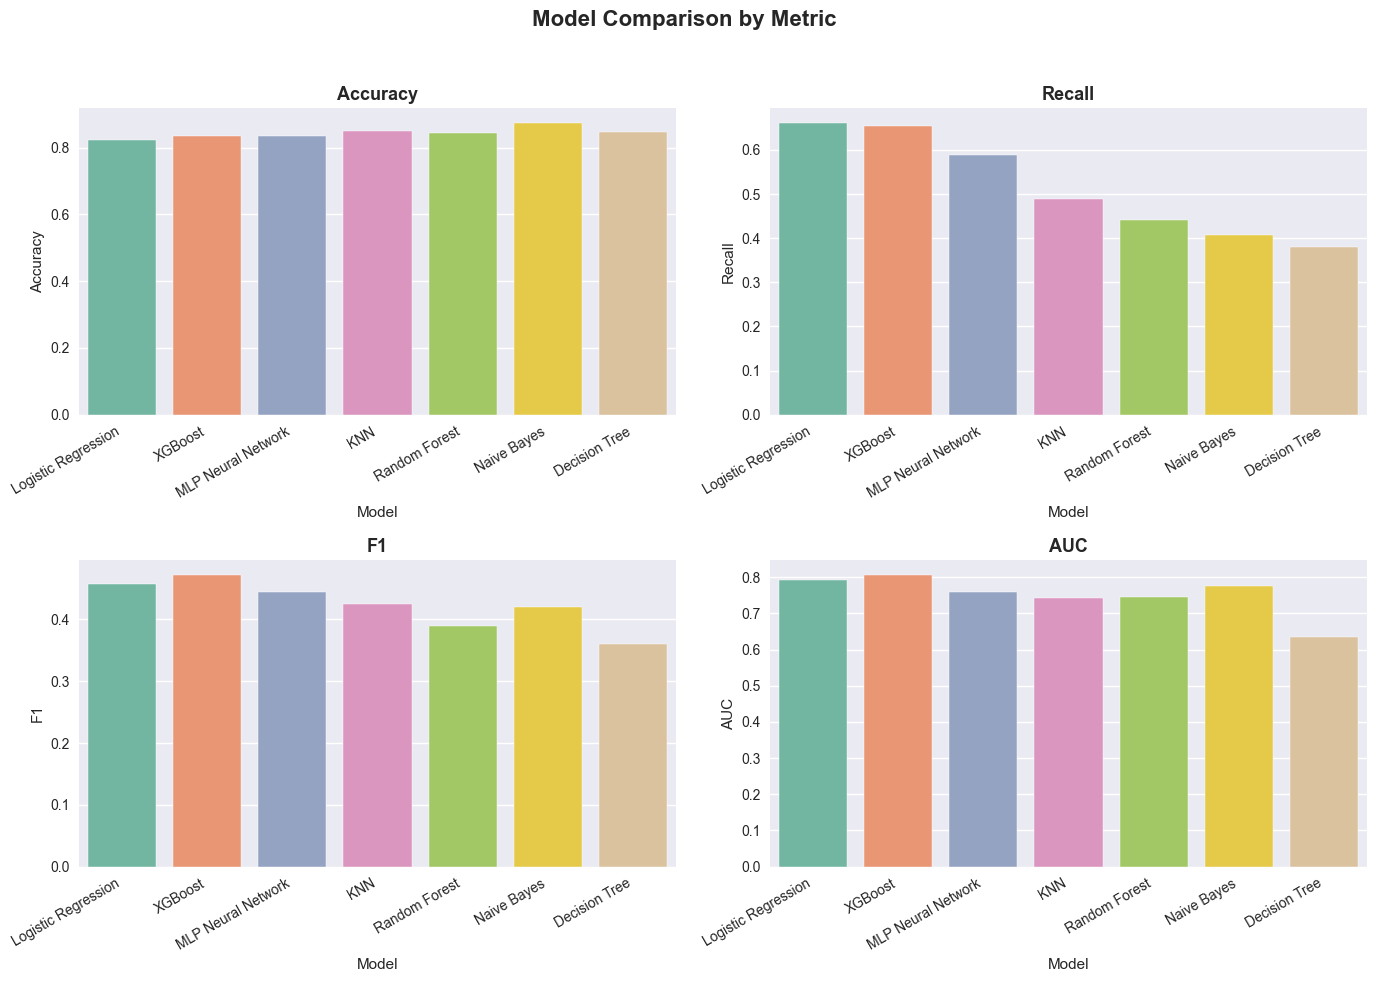

In [55]:
metrics = ["Accuracy", "Recall", "F1", "AUC"]
df_plot = df_results.copy().sort_values(by="Recall", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Comparison by Metric", fontsize=16, fontweight='bold')

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    sns.barplot(data=df_plot, x="Model", y=metric, palette="Set2", ax=ax)
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


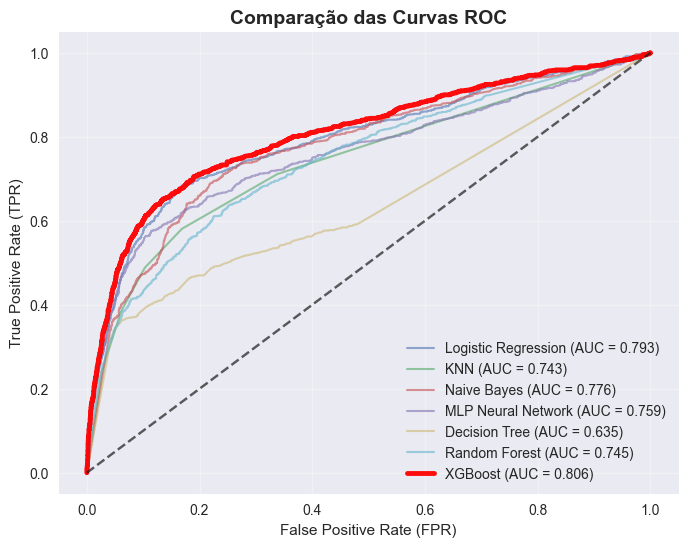

In [56]:
plt.figure(figsize=(8, 6))

# Lista dos modelos e dados a usar
modelos = [
    ("Logistic Regression", lr, X_test_scaled),
    ("KNN", knn, X_test_scaled),
    ("Naive Bayes", nb, X_test_scaled),
    ("MLP Neural Network", mlp, X_test_scaled),
    ("Decision Tree", dt, X_test),
    ("Random Forest", rf, X_test),
    ("XGBoost", xgb, X_test)
]

for nome, modelo, X_data in modelos:
    if hasattr(modelo, "predict_proba"):
        probs = modelo.predict_proba(X_data)[:, 1]
    else:
        probs = modelo.decision_function(X_data)

    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)

    # Destaque especial para XGBoost
    if nome == "XGBoost":
        plt.plot(fpr, tpr, 
                 label=f"{nome} (AUC = {auc:.3f})", 
                 color="red", linewidth=3.5, alpha=0.95)
    else:
        plt.plot(fpr, tpr, 
                 label=f"{nome} (AUC = {auc:.3f})", 
                 linewidth=1.5, alpha=0.6)

# Linha diagonal de referência (aleatório)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)

plt.title("Comparação das Curvas ROC", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


### Justificação da Escolha do Modelo Final

No contexto deste problema, a métrica mais relevante é o **Recall**, uma vez que o objetivo da campanha é **identificar o maior número possível de clientes com potencial para subscrever o depósito a prazo**.  
Perder um cliente interessado (falso negativo) é mais prejudicial do que contactar um cliente que não aceita (falso positivo).

A **Logistic Regression** apresentou o **maior Recall (~0.66)**, demonstrando elevada capacidade de identificar corretamente potenciais subscritores. É um modelo **estável, simples e interpretável**, o que facilita a sua utilização em contexto de negócio.

No entanto, o **XGBoost** apresentou uma performance **muito próxima em Recall (~0.65)**, mas com **melhor desempenho global em F1 e AUC (~0.81)**.  
Isto significa que o XGBoost **mantém praticamente a mesma capacidade de identificar clientes interessados**, mas consegue **reduzir o número de falsos positivos e priorizar melhor os clientes a contactar**, resultando em **decisões de campanha mais eficientes** e com **menor desperdício de recursos**.

Assim, considerando o equilíbrio entre eficácia preditiva e impacto operacional, o **modelo final selecionado** é:

> **XGBoost**, por apresentar um compromisso mais vantajoso entre Recall e desempenho global, permitindo **maximizar o número de potenciais clientes identificados** enquanto **reduz contactos desnecessários e custos associados à campanha**.


### Comparação das Curvas ROC

A Curva ROC compara o trade-off entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) ao longo de diferentes limiares de decisão.  
Quanto mais a curva se afasta da diagonal aleatória, melhor é a capacidade do modelo distinguir entre clientes que subscrevem e não subscrevem.

Observou-se que o **XGBoost** apresentou a curva mais distante da diagonal, com o **maior AUC (≈ 0.81)**, indicando **melhor separação entre as classes**.  
A Logistic Regression e o MLP também apresentaram curvas relativamente elevadas, mas com desempenho inferior.  
Já modelos como Decision Tree, Naive Bayes e KNN apresentaram curvas próximas da diagonal, indicando **menor capacidade discriminativa**.

Este resultado reforça a escolha do **XGBoost como modelo final**, não só pelo seu Recall elevado, mas também pela sua maior capacidade de distinguir corretamente as classes.


### Otimização Treshold XGBoost

In [57]:
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
resultados_threshold = []

for t in thresholds:
    y_pred_adj = (y_prob_xgb >= t).astype(int)
    resultados_threshold.append([t,
                                 recall_score(y_test, y_pred_adj),
                                 precision_score(y_test, y_pred_adj)])

df_threshold = pd.DataFrame(resultados_threshold, columns=["Threshold", "Recall", "Precision"])
df_threshold


,Threshold,Recall,Precision
0,0.10,0.99,0.11
1,0.15,0.98,0.12
2,0.20,0.94,0.13
3,0.25,0.90,0.15
4,0.30,0.84,0.18
5,0.35,0.79,0.22
6,0.40,0.73,0.28
7,0.45,0.69,0.33
8,0.50,0.65,0.37
9,0.55,0.62,0.42


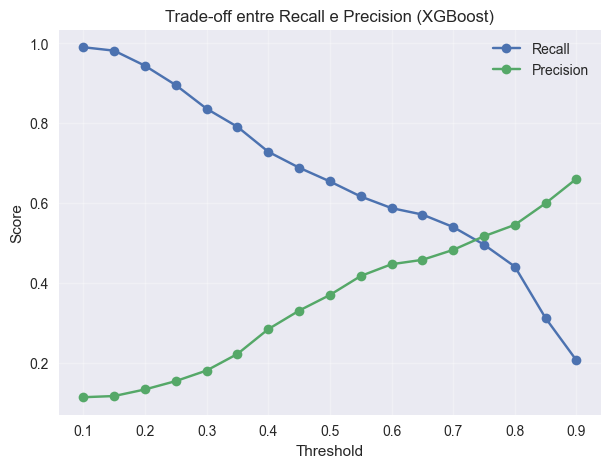

In [58]:
plt.figure(figsize=(7,5))
plt.plot(df_threshold["Threshold"], df_threshold["Recall"], label="Recall", marker='o')
plt.plot(df_threshold["Threshold"], df_threshold["Precision"], label="Precision", marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Trade-off entre Recall e Precision (XGBoost)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [59]:
threshold_otimo = 0.35

y_pred_final = (y_prob_xgb >= threshold_otimo).astype(int)

print("Recall (classe 'yes'):", recall_score(y_test, y_pred_final))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_final))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_final))


Recall (classe 'yes'): 0.790948275862069

Matriz de Confusão:
 [[4734 2574]
 [ 194  734]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.96      0.65      0.77      7308
           1       0.22      0.79      0.35       928

    accuracy                           0.66      8236
   macro avg       0.59      0.72      0.56      8236
weighted avg       0.88      0.66      0.73      8236



### Ajuste do Threshold de Decisão

O modelo **XGBoost** produz como saída uma **probabilidade de subscrição**.  
Por defeito, considera-se a classe positiva (`yes`) quando a probabilidade é **≥ 0.50**.  
No entanto, dado que o objetivo principal do problema é **maximizar o Recall** — isto é, **detetar o maior número possível de potenciais subscritores** — foi realizado um **ajuste do threshold de decisão**.

Foram avaliados diferentes valores de limiar entre **0.10 e 0.90**, analisando o compromisso entre **Recall** e **Precision**.  
Observou-se que **thresholds mais baixos** aumentam significativamente o Recall, embora impliquem uma redução moderada na Precision, refletindo o aumento de falsos positivos.

O **threshold final selecionado foi 0.35**, por apresentar um **equilíbrio adequado** entre as duas métricas:
- **Recall elevado (~0.79)**, reduzindo substancialmente os falsos negativos (clientes que subscreveriam mas não seriam contactados);
- **Precision aceitável (~0.22)**, mantendo os contactos desnecessários sob controlo.

Com este ajuste, o modelo torna-se **mais alinhado com os objetivos da campanha comercial**, assegurando que **menos clientes potencialmente interessados são ignorados**, mesmo que à custa de um ligeiro aumento de falsos positivos.


### Lista de clientes prioritários

In [60]:
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

In [61]:
df_prioridade = X_test.copy()
df_prioridade["Probabilidade_Subscription"] = y_prob_xgb
df_prioridade["Predição_Final"] = (y_prob_xgb >= 0.35).astype(int)

In [62]:
df_prioridade = df_prioridade.sort_values(by="Probabilidade_Subscription", ascending=False).reset_index()

In [63]:
df_prioridade.head(20)

,index,cons.price.idx,education_university.degree,default_no,pdays,cons.conf.idx,job_retired,month_oct,job_student,housing,month_may,poutcome_nonexistent,emp.var.rate,poutcome_success,campaign,month_mar,euribor3m,was_prev_contacted,contact_telephone,job_blue-collar,month_sep,month_dec,Probabilidade_Subscription,Predição_Final
0,39134,93.37,False,1,6.00,-34.80,True,False,False,1,False,False,-1.80,True,1,True,0.66,1,False,False,False,False,0.99,1
1,39147,93.37,False,1,5.00,-34.80,False,False,True,1,False,False,-1.80,True,1,True,0.66,1,False,False,False,False,0.99,1
2,39220,93.37,True,1,6.00,-34.80,False,False,False,1,False,False,-1.80,True,1,True,0.65,1,False,False,False,False,0.99,1
3,39218,93.37,False,1,6.00,-34.80,False,False,False,0,False,False,-1.80,True,1,True,0.65,1,False,False,False,False,0.99,1
4,40172,94.22,True,1,13.00,-40.30,False,False,False,1,False,False,-1.70,True,2,False,0.86,1,False,False,False,False,0.99,1
5,40697,94.20,False,1,6.00,-37.50,True,False,False,0,False,False,-1.10,True,3,False,0.88,1,False,False,True,False,0.99,1
6,40117,94.22,True,1,6.00,-40.30,True,False,False,1,False,False,-1.70,True,1,False,0.83,1,False,False,False,False,0.99,1
7,40044,94.22,True,1,3.00,-40.30,False,False,False,0,False,False,-1.70,True,1,False,0.80,1,False,False,False,False,0.99,1
8,39175,93.37,False,1,10.00,-34.80,False,False,False,0,False,False,-1.80,True,2,True,0.65,1,False,True,False,False,0.98,1
9,40050,94.22,False,1,3.00,-40.30,False,False,False,1,False,False,-1.70,True,2,False,0.80,1,False,False,False,False,0.98,1


Com base no modelo final selecionado (XGBoost com threshold ajustado), foi calculada a probabilidade de cada cliente no conjunto de teste subscrever o depósito a prazo.  
A tabela acima apresenta os **20 clientes com maior probabilidade prevista de subscrição**, ordenados de forma decrescente.

Esta lista não implica ação real, mas demonstra como o modelo pode ser utilizado para **prioritizar contactos** em campanhas futuras, garantindo que os clientes com maior propensão sejam considerados primeiro.


## 5. Conclusões

O presente trabalho permitiu desenvolver um modelo preditivo de suporte à decisão para campanhas de telemarketing direcionadas à subscrição de depósitos a prazo. Após a fase de preparação dos dados, tratamento do desbalanceamento da variável alvo e seleção de atributos relevantes, foram testados vários algoritmos de classificação. A métrica central adotada foi o **Recall da classe “yes”**, uma vez que o objetivo principal consiste em **maximizar a identificação de potenciais subscritores**, reduzindo a probabilidade de perder clientes com interesse real no produto.

Entre os modelos avaliados, o **XGBoost** apresentou o desempenho mais consistente, alcançando **Recall = 0.65** com threshold padrão (0.50) e **Recall = 0.78** após **ajuste do limiar de decisão para 0.35**. Este ajuste permitiu **reduzir falsos negativos** de forma significativa, ainda que com um aumento moderado do número de falsos positivos, o qual se considera aceitável no contexto de campanhas comerciais, onde o custo de um contacto adicional é inferior ao custo de perder um cliente aderente.

A análise das variáveis mais influentes confirmou a relevância de fatores associados ao **histórico de contacto** (p.ex., `was_prev_contacted` e `pdays`), bem como indicadores **macroeconómicos** (`euribor3m`, `cons.price.idx`, `emp.var.rate`) e características **sociodemográficas** (`age`). Estes resultados sugerem que tanto o contexto económico como o envolvimento prévio do cliente com campanhas anteriores são determinantes na probabilidade de subscrição.

Conclui-se, portanto, que o modelo desenvolvido constitui uma ferramenta eficaz para **priorizar clientes com maior propensão à subscrição**, permitindo **otimizar o planeamento de contactos, melhorar a eficiência operacional e aumentar a taxa de conversão da campanha**.


## 6. Recomendações

Com base nos resultados obtidos e na análise das variáveis mais influentes, apresentam-se as seguintes recomendações para a utilização prática do modelo no contexto de campanhas de marketing:

1. **Priorizar Contactos com Base na Probabilidade Prevista**  
   Utilizar o score de probabilidade gerado pelo XGBoost para ordenar os clientes por propensão à subscrição.  
   Os clientes com probabilidade mais elevada devem ser contactados primeiro, otimizando o retorno da campanha.

2. **Aplicar o Threshold Ajustado (0.35)**  
   A adoção deste limiar permite **maximizar o Recall**, reduzindo o número de potenciais subscritores que não seriam contactados.  
   Apesar do aumento moderado de falsos positivos, o custo operacional adicional permanece baixo face ao benefício de maior captação.

3. **Monitorizar Indicadores Macroeconómicos**  
   Variáveis como `euribor3m`, `cons.price.idx` e `cons.conf.idx` revelaram impacto significativo no comportamento dos clientes.  
   Recomenda-se ajustar a intensidade das campanhas em períodos que indiquem maior confiança económica.

4. **Valorizar Clientes com Histórico Positivo**  
   Clientes anteriormente contactados com resultado bem-sucedido (`poutcome_success`) apresentam maior probabilidade de adesão.  
   Estratégias de **follow-up estruturado** podem aumentar substancialmente a taxa de conversão.

5. **Definir Limites de Contacto por Cliente**  
   Um número excessivo de contactos (`campaign`) pode levar à saturação e reduzir o interesse.  
   Sugere-se estabelecer **um limite máximo de tentativas** e adaptar a frequência ao perfil do cliente.

6. **Re-Treinar o Modelo Periodicamente**  
   O comportamento dos clientes e o contexto económico evoluem ao longo do tempo.  
   Recomenda-se **reavaliar e re-treinar o modelo regularmente** com dados de novas campanhas para manter o desempenho.

Estas recomendações permitem a integração efetiva do modelo em processos reais de prospeção, contribuindo para **priorizar recursos, aumentar a eficácia comercial e maximizar a taxa de conversão das campanhas**.
